# Setup

## Imports & Settings

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import itertools
import scipy
import scanpy as sc
import seaborn as sb
import pandas as pd
import numpy as np
import corescpy as cr

# Computing Resources
gpu = False
sc.settings.n_jobs = 8
sc.settings.max_memory = 150

# Display
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(20, 20))

# Panel Information
old_seg = ["50452A", "50452B", "50452C",  # CHO-001
           "50618B5", "50564A4",  # CHO-002
           "49377A2",  # CHO-003
           "49464A4",  # ?
           "49696A4", "49559A5",  # CHO-004
           "50115A2", "50007B2",  # CHO-005
           "49471A4", "50445A3",  # CHO-006
           ]  # old segmentation = old processing arguments

# Panel & Column Names (from Metadata & To Be Created)
panel = "TUQ97N"
col_sample_id_o, col_sample_id = "Sample ID", "Sample"  # in metadata, new
col_subject = "Patient"  # in metadata file
col_inflamed, col_stricture = "Inflamed", "Stricture"  # in metadata file
col_condition = "Condition"  # constructed from col_inflamed & col_stricture
col_fff = "file_path"  # column in metadata in which to store data file path
col_tangram = "tangram_prediction"  # for future Tangram imputation annotation
col_segment = "segmentation"

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

## Options & Data

In [2]:
# Directories & Metadata
load, reannotate = False, True
# samples = "all"
# run = "CHO-008"
run = None  # just look for samples in all runs
# samples = ["50452A", "50452B", "50006A", "50006B",
#            # "50217A", "50217B",  # exclude because weird
#            "50336B", "50336C",
#            # "50403A1",  # exclude because low quality
#            "50403A2", "50403B"]  # paired (un)inflamed
samples = ["50403C2"]  # paired (un)inflamed

# Optionally, Define Manual Annotation Versions
# should be stored in ("<out_dir>/annotations_dictionaries")
# in format <selves[i]._library_id>___leiden_<man_anns[i]>_dictionary.xlsx
# with first column = leiden cluster and second column = annotation
man_anns = True  # load manual annotations according to clustering kws
# man_anns = ["res0pt5_dist0pt5_npc30", "res0pt75_dist0pt3_npc30",
#             "res1pt5_dist0_npc30"]  # choose manual annotations to load
# man_anns = None  # do not load manual annotations

# Main Directories
# Replace manually or mirror my file/directory tree in your home (`ddu`)
ddu = os.path.expanduser("~")
ddm = "/mnt/cho_lab" if os.path.exists("/mnt/cho_lab") else "/mnt"  # Spark?
ddl = f"{ddm}/disk2/{os.getlogin()}/data/shared-xenium-library" if (
    "cho" in ddm) else os.path.join(ddu, "shared-xenium-library")
ddx = f"{ddm}/bbdata2"  # mounted drive Xenium folder
out_dir = os.path.join(ddl, "outputs", "TUQ97N", "nebraska")  # None = no save
d_path = os.path.join(ddm, "disk2" if "cho" in ddm else "",
                      os.getlogin(), "data")  # other, e.g., Tangram data
anf = pd.read_csv(os.path.join(ddu, "corescpy/examples/markers_lineages.csv"))
file_mdf = os.path.join(ddl, "samples.csv")  # metadata

# Annotation & Tangram Imputation
# col_cell_type_sc, file_sc = "ClusterAnnotation", str(
#     f"{d_path}/2023-05-12_CombinedCD-v2_ileal_new.h5ad")
col_cell_type_sc, file_sc = "cell_type", f"{d_path}/elmentaite_ileal.h5ad"
# file_sc = None  # to skip Tangram imputation/label transfer

# Processing & Clustering Options
kws_pp = dict(cell_filter_pmt=None, cell_filter_ncounts=[15, None],
              cell_filter_ngene=[3, None], gene_filter_ncell=[3, None],
              gene_filter_ncounts=[3, None], custom_thresholds=None,
              kws_scale=dict(max_value=10, zero_center=True),
              method_norm="log")  # preprocessing keyword arguments
kws_pp_o = dict(cell_filter_pmt=None, cell_filter_ncounts=[50, None],
                cell_filter_ngene=[10, None], gene_filter_ncell=[3, None],
                gene_filter_ncounts=[3, None], custom_thresholds=None,
                kws_scale=dict(max_value=10, zero_center=True),
                method_norm="log")  # old segmentation preprocessing arguments
kws_cluster = dict(kws_umap=dict(method="rapids" if gpu else "umap"),
                   genes_subset=list(anf.iloc[:, 0]),  # use only markers
                   use_gpu=gpu, use_highly_variable=False)
kws_clustering, col_assignment = {}, []
for i in zip([0.5, 0.75, 1.5], [0.5, 0.3, 0], [30, 30, 30]):
    kws = {**kws_cluster, "resolution": i[0], "kws_umap": {
        **kws_cluster["kws_umap"], "min_dist": i[1]}, "n_comps": i[2]}
    suff = str(f"res{re.sub('[.]', 'pt', str(kws['resolution']))}_dist"
               f"{re.sub('[.]', 'pt', str(kws['kws_umap']['min_dist']))}"
               f"_npc{kws['n_comps']}")  # file path suffix
    kws_clustering.update({suff: kws})
    col_assignment += ["group" if kws["resolution"] >= 0.7 else "Bucket"]
kws_clustering = {k: v for k, v in reversed(list(
    kws_clustering.items()))}  # high resolution 1st
col_assignment = [x for x in reversed(col_assignment)]  # high resolution 1st
if man_anns is True:
    man_anns = list(kws_clustering.keys())
col_cell_type = list(kws_clustering.keys())[-1] if (
    man_anns is None) else f"manual_{man_anns[-1]}"  # default cell labels

# After this point, no more options to specify
# Just code to infer the data file path from your specifications
# and construct argument dictionaries and manipulate metadata and such.

# Read Metadata & Other Information
metadata = (pd.read_excel if file_mdf[-4:] == "xlsx" else pd.read_csv)(
    file_mdf, dtype={"Slide ID": str}).rename({
        "Name": col_subject, "Inflammation": col_inflamed}, axis=1)
metadata.loc[:, col_segment] = "new"
metadata.loc[metadata[col_sample_id_o].isin(old_seg), col_segment] = "old"
if samples not in ["all", None]:  # subset by sample ID?
    metadata = metadata.set_index(col_sample_id_o).loc[samples].reset_index()

# Revise Metadata & Construct Variables from Options
metadata.loc[:, col_condition] = metadata.apply(lambda x: "Stricture" if x[
    col_stricture].lower() in ["stricture", "yes"] else x[
        col_inflamed].capitalize(), axis=1)  # inflamation/stricture condition
metadata.loc[:, col_sample_id] = metadata[[col_condition, col_sample_id_o]
                                          ].apply("-".join, axis=1)
metadata = metadata.set_index(col_sample_id)
fff = np.array(cr.pp.construct_file(run=run, directory=ddx, panel_id=panel))
bff = np.array([os.path.basename(i) for i in fff])  # base path names
samps = np.array([i.split("__")[2].split("-")[0] for i in fff])
for x in metadata[col_sample_id_o]:
    m_f = metadata[metadata[col_sample_id_o] == x][
        "out_file"].iloc[0]  # ...use to find unconventionally-named files
    locx = np.where(samps == x)[0] if pd.isnull(
        m_f) else np.where(bff == m_f)[0]
    metadata.loc[metadata[col_sample_id_o] == x, col_fff] = fff[locx[0]] if (
        len(locx) > 0) else np.nan  # assign output file to metadata row
metadata = metadata.dropna(subset=[col_fff]).drop_duplicates()

# Annotation File
assign = anf.dropna(subset=col_assignment).set_index(
    "gene").rename_axis("Gene")  # markers
# assign = assign[~assign.Quality.isin([-1])]  # drop low-quality markers

# Print Metadata & Make Output Directory (If Not Present)
print(metadata[[col_sample_id_o, col_subject, col_condition,
                col_inflamed, col_stricture, col_segment]])
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Load Data
kws_init = dict(col_sample_id=col_sample_id, col_subject=col_subject,
                col_cell_type=col_cell_type)  # object creation arguments
selves = [None] * metadata.shape[0]  # to hold different samples
for i, x in enumerate(metadata.index.values):
    selves[i] = cr.Spatial(metadata.loc[x][col_fff], library_id=x, **kws_init)
    for j in metadata:  # iterate metadata columns
        selves[i].rna.obs.loc[:, j] = str(metadata.loc[x][j])  # add to object
    selves[i].rna.obs.loc[:, "out_file"] = os.path.join(
        out_dir, selves[i]._library_id)  # output path (to save object)
    if load is True:
        if os.path.exists(str(selves[i].rna.obs.out_file.iloc[0]) + ".h5ad"):
            selves[i].update_from_h5ad(selves[i].rna.obs.out_file.iloc[0])
        print(selves[i].rna)

# Marker Gene Dictionary (for Scanpy Plotting)
marker_genes_dict = dict(assign["Bucket"].reset_index().groupby(
    "Bucket").apply(lambda x: list(pd.unique(list(set(
        x.Gene).intersection(selves[0].rna.var_names))))))  # to dictionary

                  Sample ID  Patient  Condition  Inflamed Stricture  \
Sample                                                                
Stricture-50403C2   50403C2    50403  Stricture  inflamed       yes   

                  segmentation  
Sample                          
Stricture-50403C2          new  


<<< INITIALIZING SPATIAL CLASS OBJECT >>>

INFO     reading                                                                                                   
         /mnt/cho_lab/bbdata2/outputs/TUQ97N/CHO-012/output-XETG00189__0021979__50403C2-TUQ97N-EA__20240516__190239
         /cell_feature_matrix.h5                                                                                   


Counts: Initial


	Observations: 844288

	Genes: 469







 AnnData object with n_obs × n_vars = 844288 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 

## Manual Annotations

### Load Manual Annotations

In [ ]:
if man_anns is not None and man_anns is not False:
    for i, s in enumerate(selves):
        for r in man_anns:  # iterate Leiden clusterings
            fmr = os.path.join(out_dir, "annotation_dictionaries", str(
                f"{s._library_id}___leiden_{r}_dictionary.xlsx"))  # mappings
            if os.path.exists(fmr) is False:
                print(f"{fmr} file NOT found.")
                continue
            else:
                print(f"{fmr} file found.")
            if f"leiden_{r}" not in s.rna.obs:
                print(f"leiden_{r} not found in adata")
                continue
            fmr = pd.read_excel(fmr).iloc[:, :2].astype(str)
            mans = dict(fmr.set_index(fmr.columns[0]).iloc[:, 0])
            s.rna.obs.loc[:, f"manual_{r}"] = s.rna.obs[f"leiden_{r}"].astype(
                int).astype(str).replace(mans)  # Leiden -> manual annotation
            s.rna.obs.loc[s.rna.obs[f"manual_{r}"].isnull(
                ), f"manual_{r}"] = s.rna.obs.loc[s.rna.obs[
                    f"manual_{r}"].isnull(), f"leiden_{r}"].astype(
                        str)  # missing annotations replaced with Leiden
            s.rna.obs.loc[:, f"manual_{r}"] = s.rna.obs[
                f"manual_{r}"].astype("category")  # as categorical
            # s.plot_spatial(f"manual_{r}")

### Write Manual Annotations

In [ ]:
if man_anns not in [None, False] and out_dir is not None:
    for i, s in enumerate(selves):
        for r in man_anns:
            if f"manual_{r}" in s.rna.obs:
                s.write_clusters(out_dir, col_cell_type=f"manual_{r}",
                                 overwrite=True,
                                 file_prefix=f"{s._library_id}__")
        s.write(s.rna.obs.out_file.iloc[0])

# Clustering

## Processing, Leiden, Annotation



 {'cell_filter_pmt': None, 'cell_filter_ncounts': [15, None], 'cell_filter_ngene': [3, None], 'gene_filter_ncell': [3, None], 'gene_filter_ncounts': [3, None], 'custom_thresholds': None, 'kws_scale': {'max_value': 10, 'zero_center': True}, 'method_norm': 'log'} 




AnnData object with n_obs × n_vars = 844288 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample', 'Sample ID', 'Patient', 'Status', 'Slide Id', 'Project', 'Location', 'Stricture', 'GRID ID', 'Inflamed', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Unnamed: 29', 'out_file', 'segmentation', 'Condition', 'file_path'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts'

Un-Used Keyword Arguments: {'assay_protein': None, 'col_condition': None, 'col_num_umis

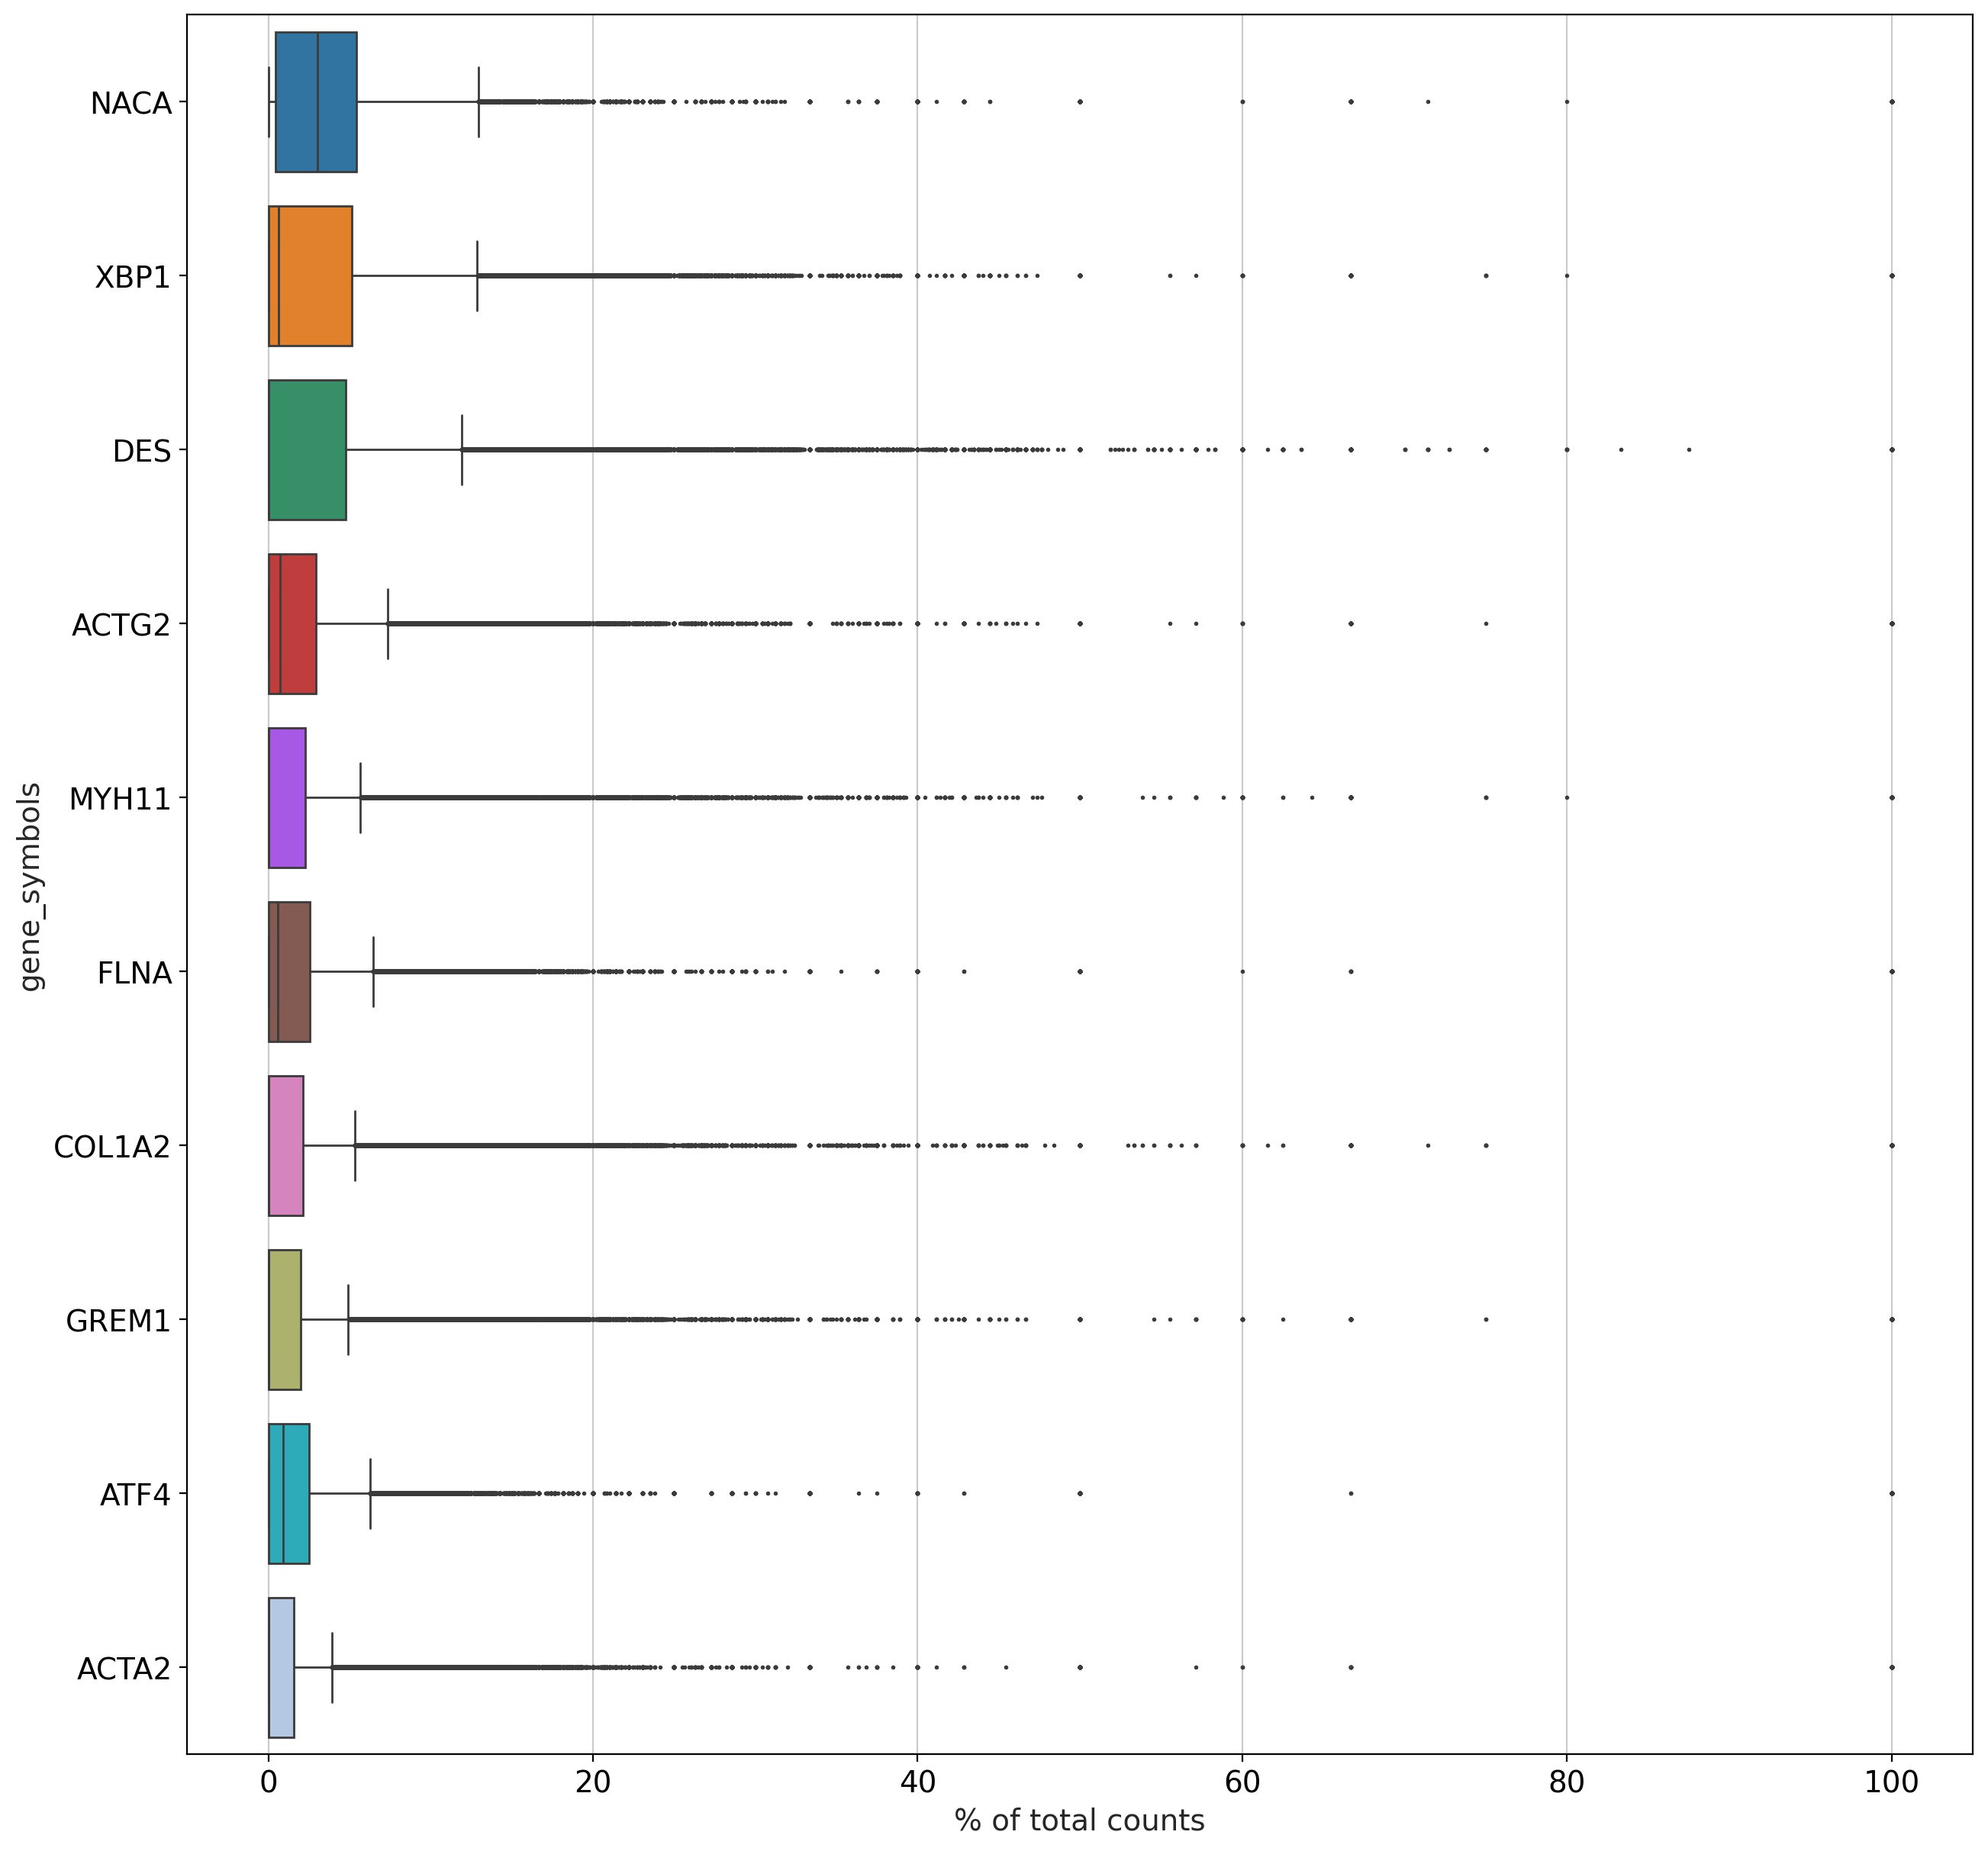



Counts: Initial


	Observations: 844288

	Genes: 469





<<< PERFORMING QUALITY CONTROL ANALYSIS>>>

	*** Detecting Mitochondrial, Ribosomal, Hemoglobin genes...

	*** Calculating & plotting QC metrics...




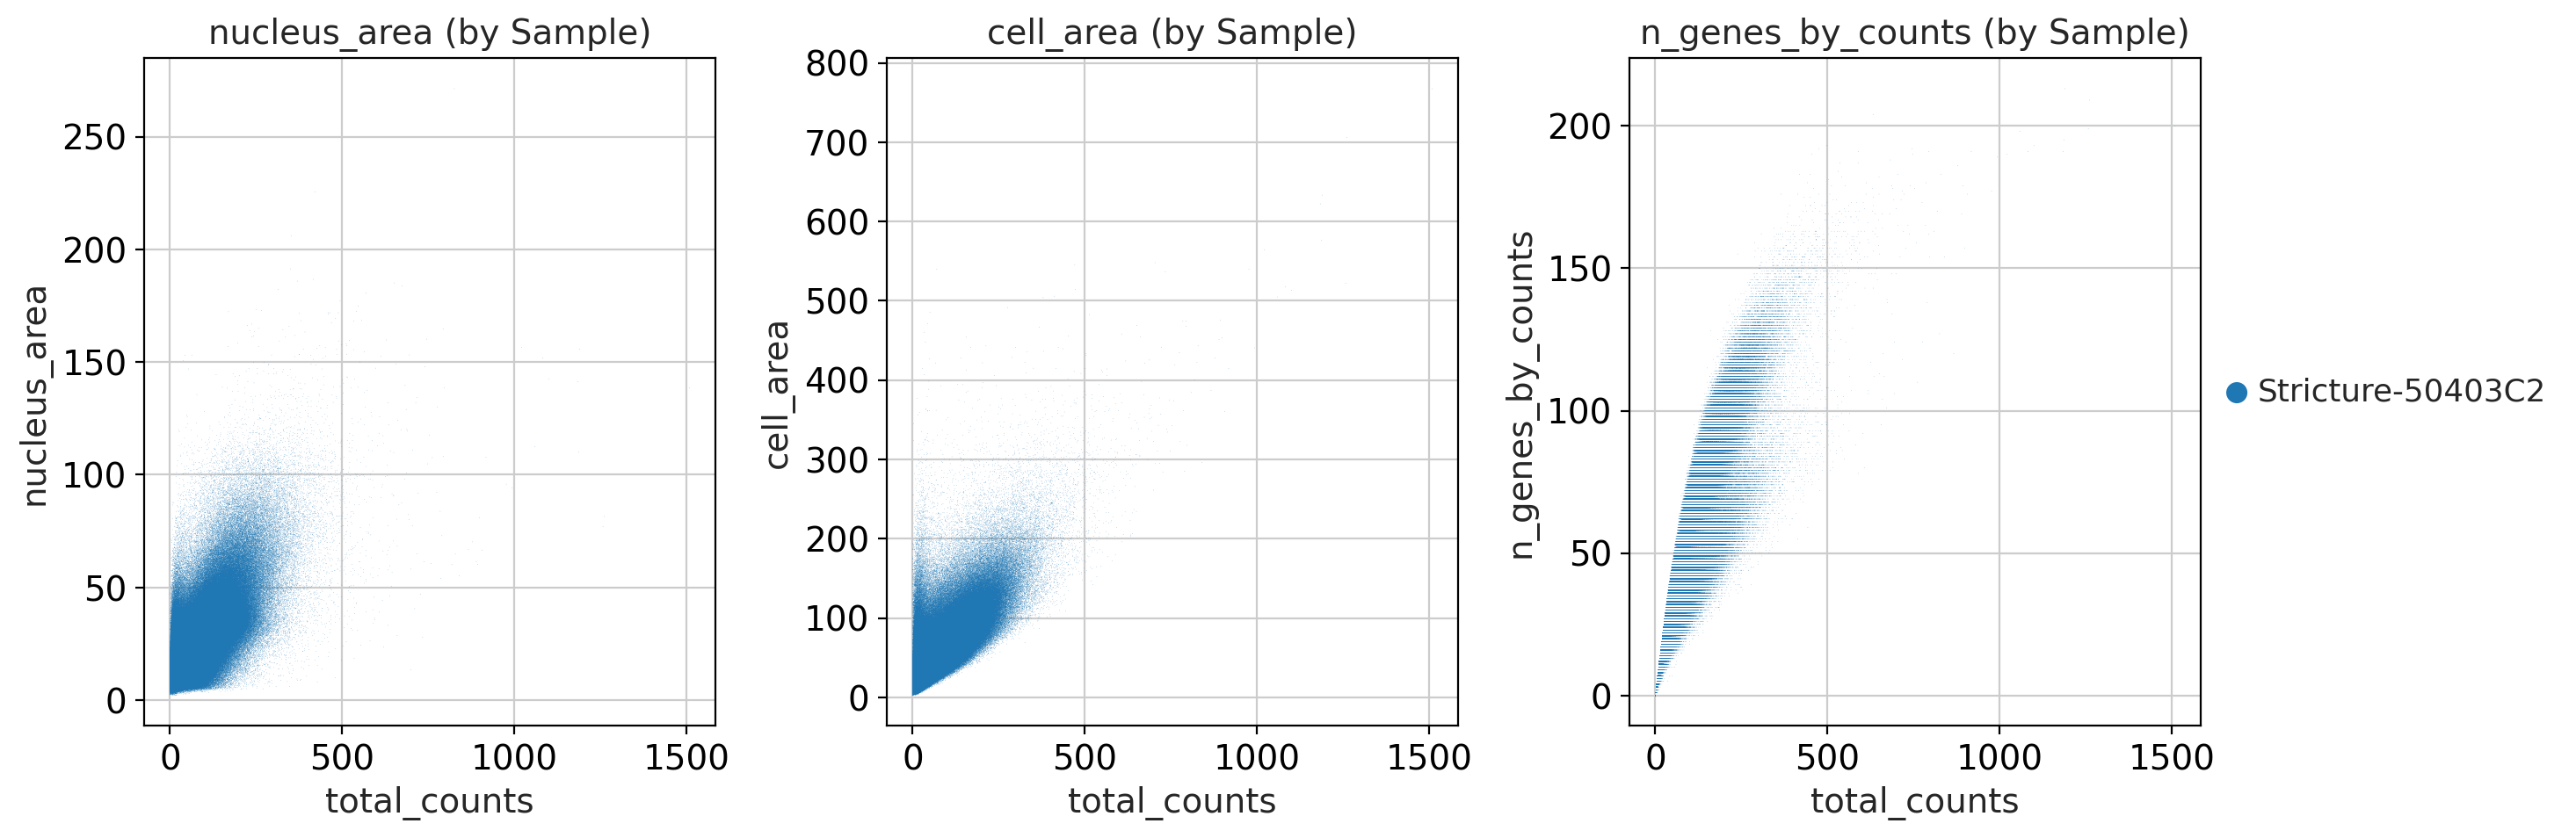


<<< FILTERING CELLS (TOO FEW GENES) & GENES (TOO FEW CELLS) >>>


Counts: Post-`min_gene`


	Observations: 833896

	Genes: 469

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%            14719.0     0.019355           0.019170              85.833270   
50%            58907.0     0.088471           0.084774              93.022878   
75%           119608.0     0.196754           0.179613              98.256638   

     total_counts  log1p_total_counts  
25%       16341.0            9.701494  
50%       74695.0           11.221182  
75%      166117.0           12.020453  





Counts: Post-`min_cell`


	Observations: 833896

	Genes: 469

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%            14719.0     0.019355           0.019170              85.833270   
50%            58907.0     0.088471           0.084774              93.022878   
75%           119608.0     0.196754           0.179613              98.25663

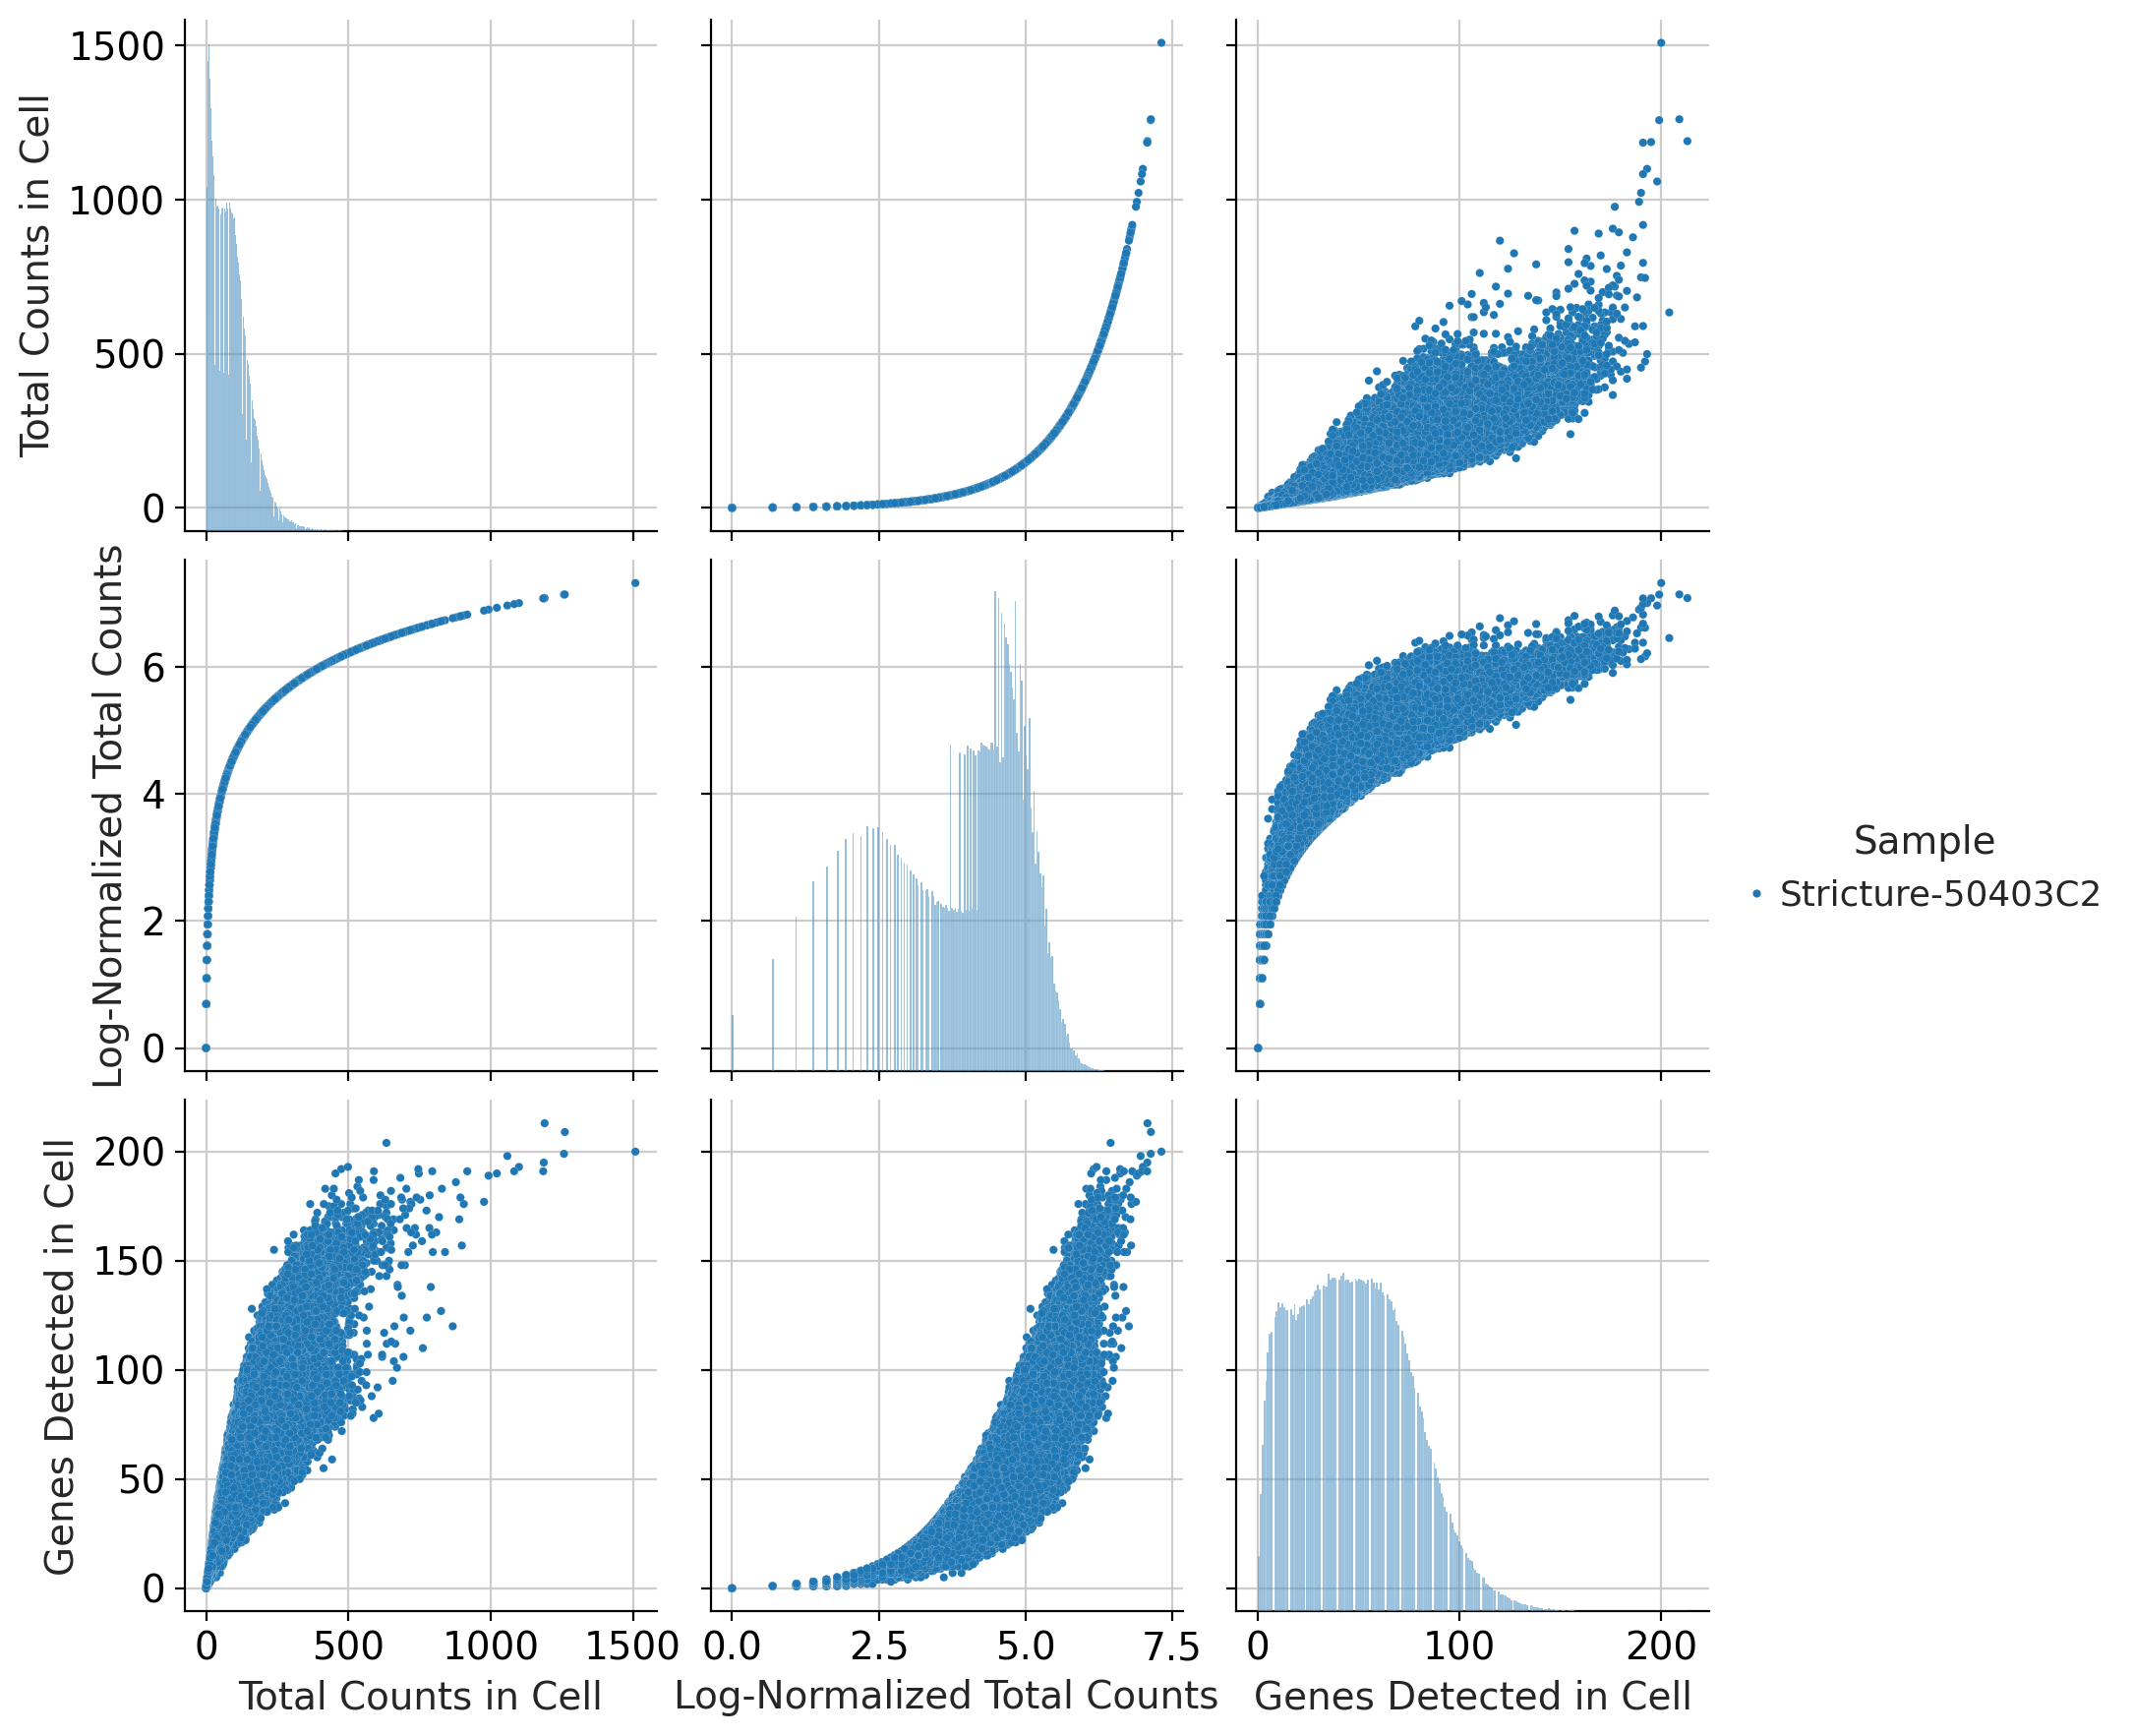

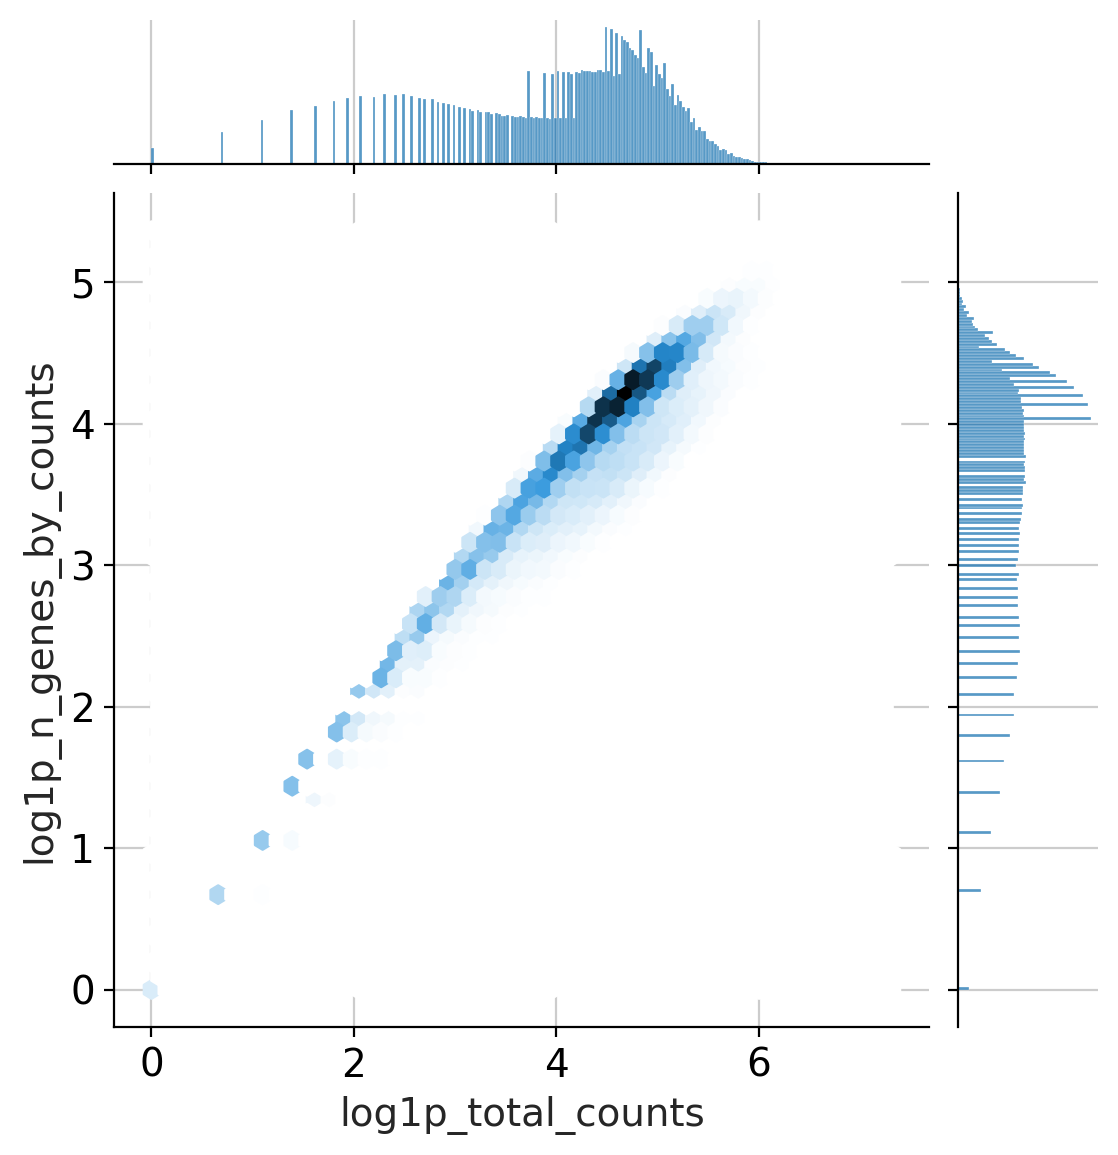

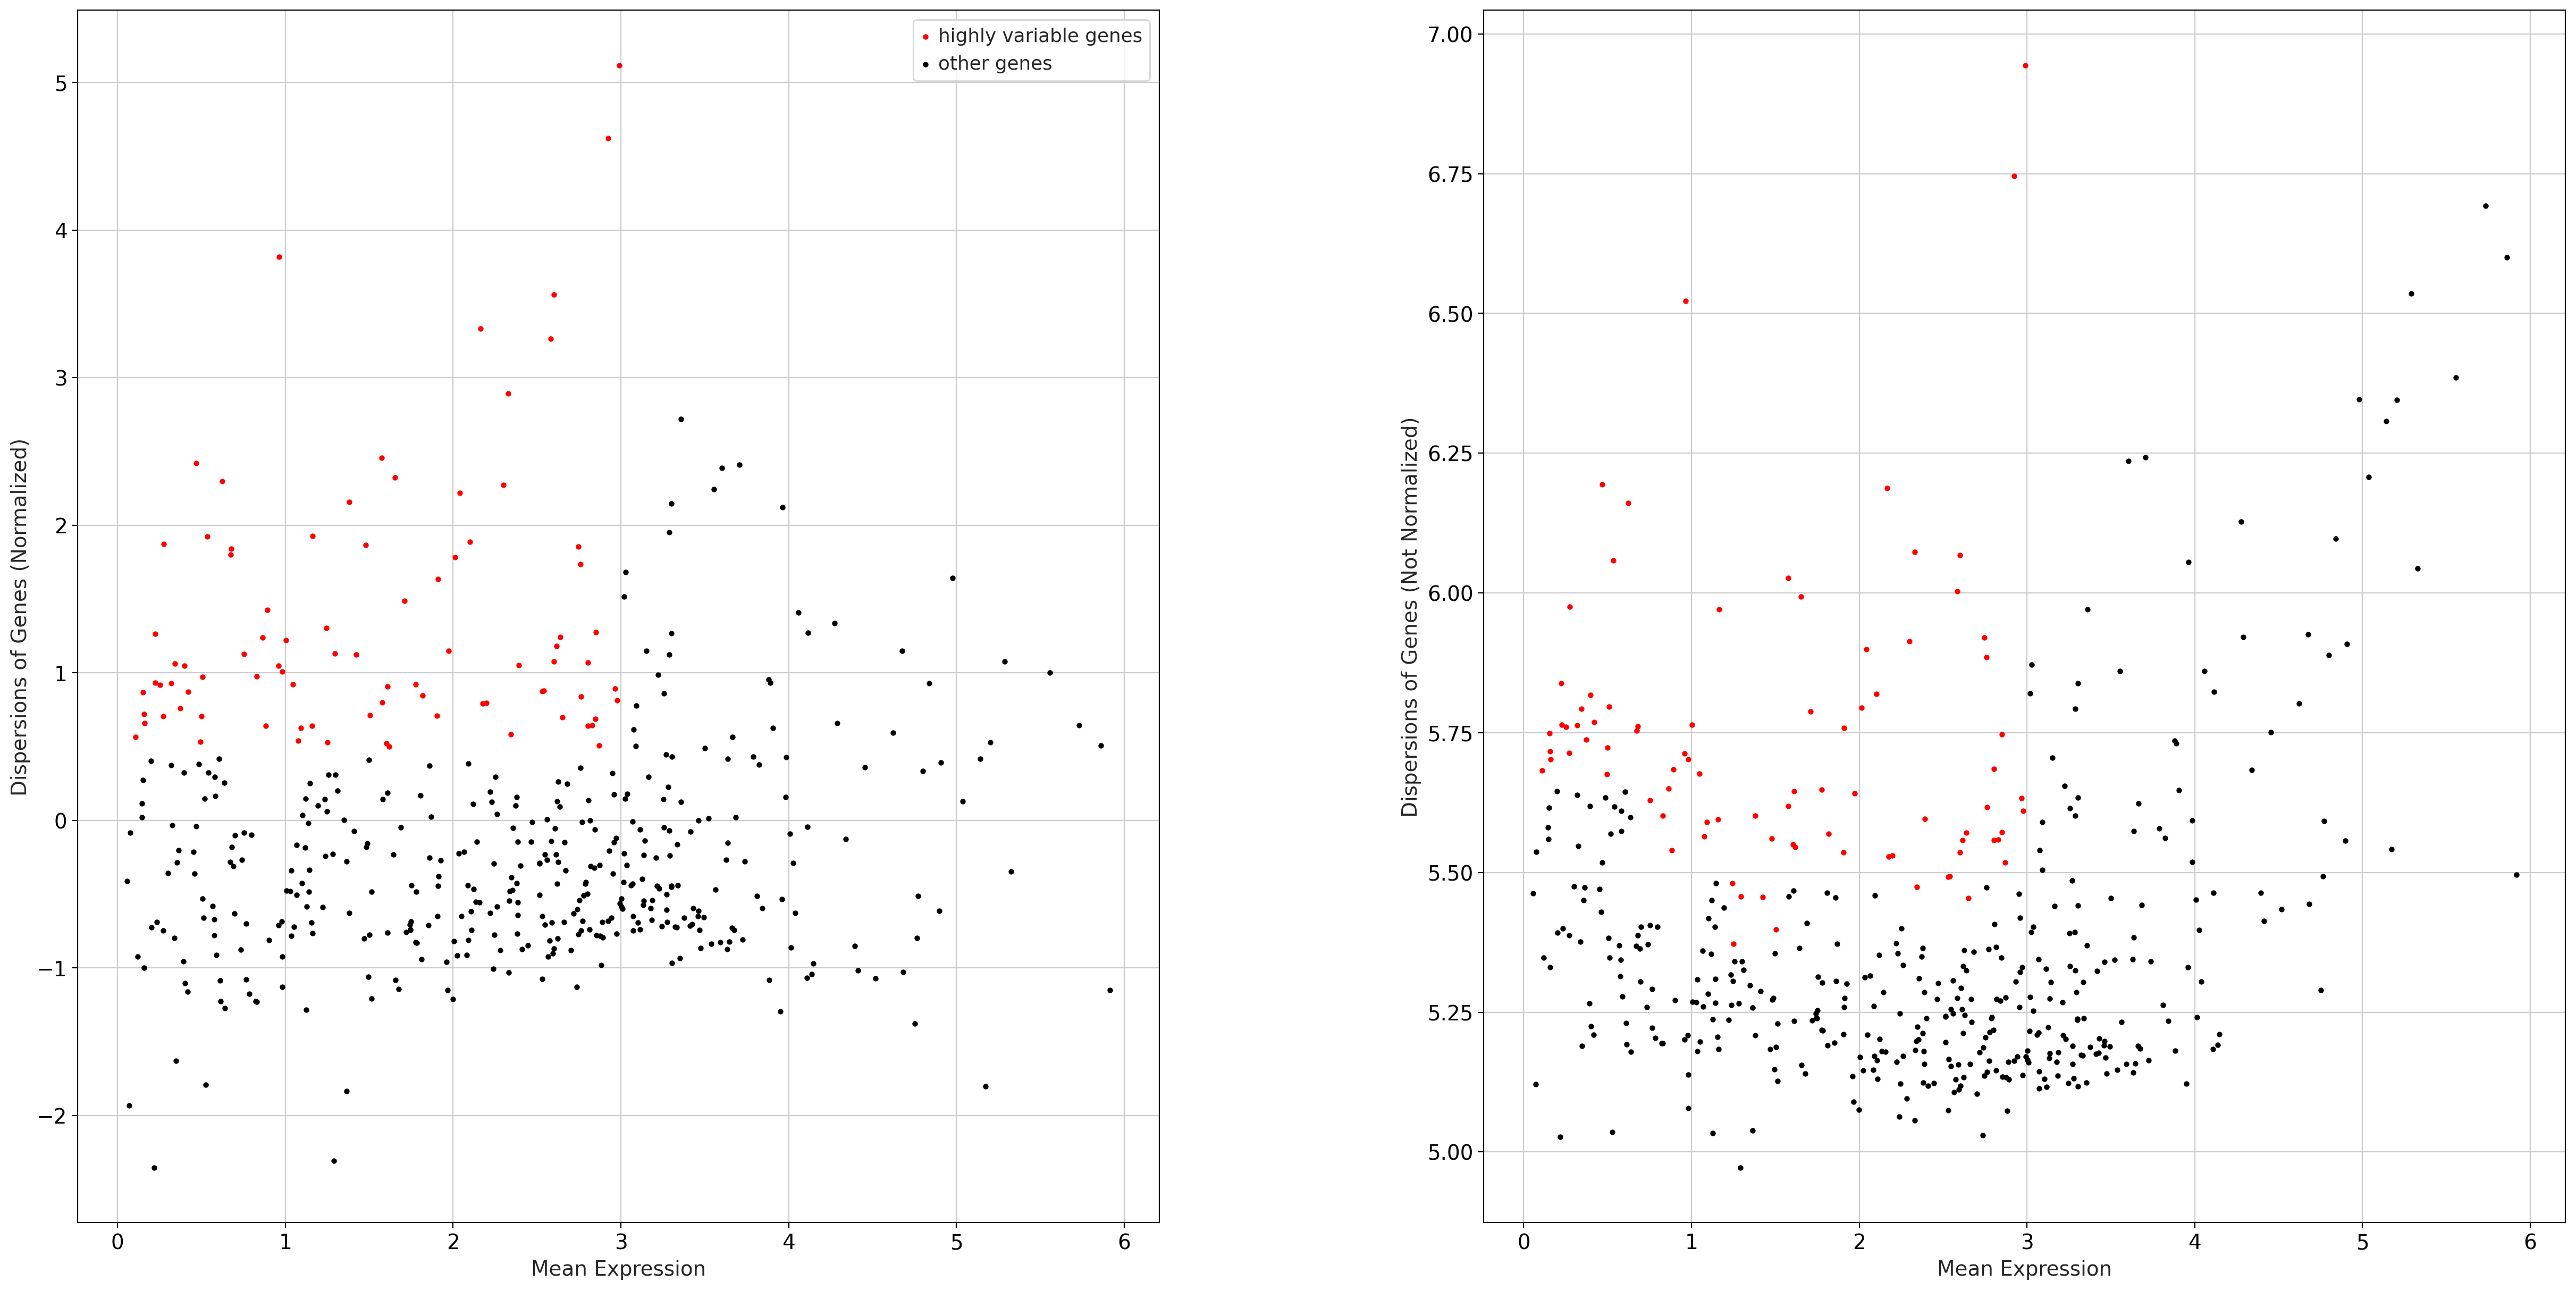


<<< NORMALIZING RAW GENE EXPRESSION >>>

	*** Scaling gene expression...

	*** Clipping maximum GEX SD to 10...

	*** Scaling => `.X` & scaled layer...


Counts: Post-Processing


	Observations: 750372

	Genes: 469

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%            14719.0     0.019355           0.019170              85.833270   
50%            58907.0     0.088471           0.084774              93.022878   
75%           119608.0     0.196754           0.179613              98.256638   

     total_counts  log1p_total_counts   n_cells  n_counts     means  \
25%       16341.0            9.701494   14171.0   16145.0  1.163432   
50%       74695.0           11.221182   58119.0   73416.0  2.384623   
75%      166117.0           12.020453  118036.0  163997.0  3.136981   

     dispersions  dispersions_norm      mean       std  
25%     5.202188         -0.689582  0.088217  0.638120  
50%     5.330559         -0.231820  0.363192  1.253625  
75

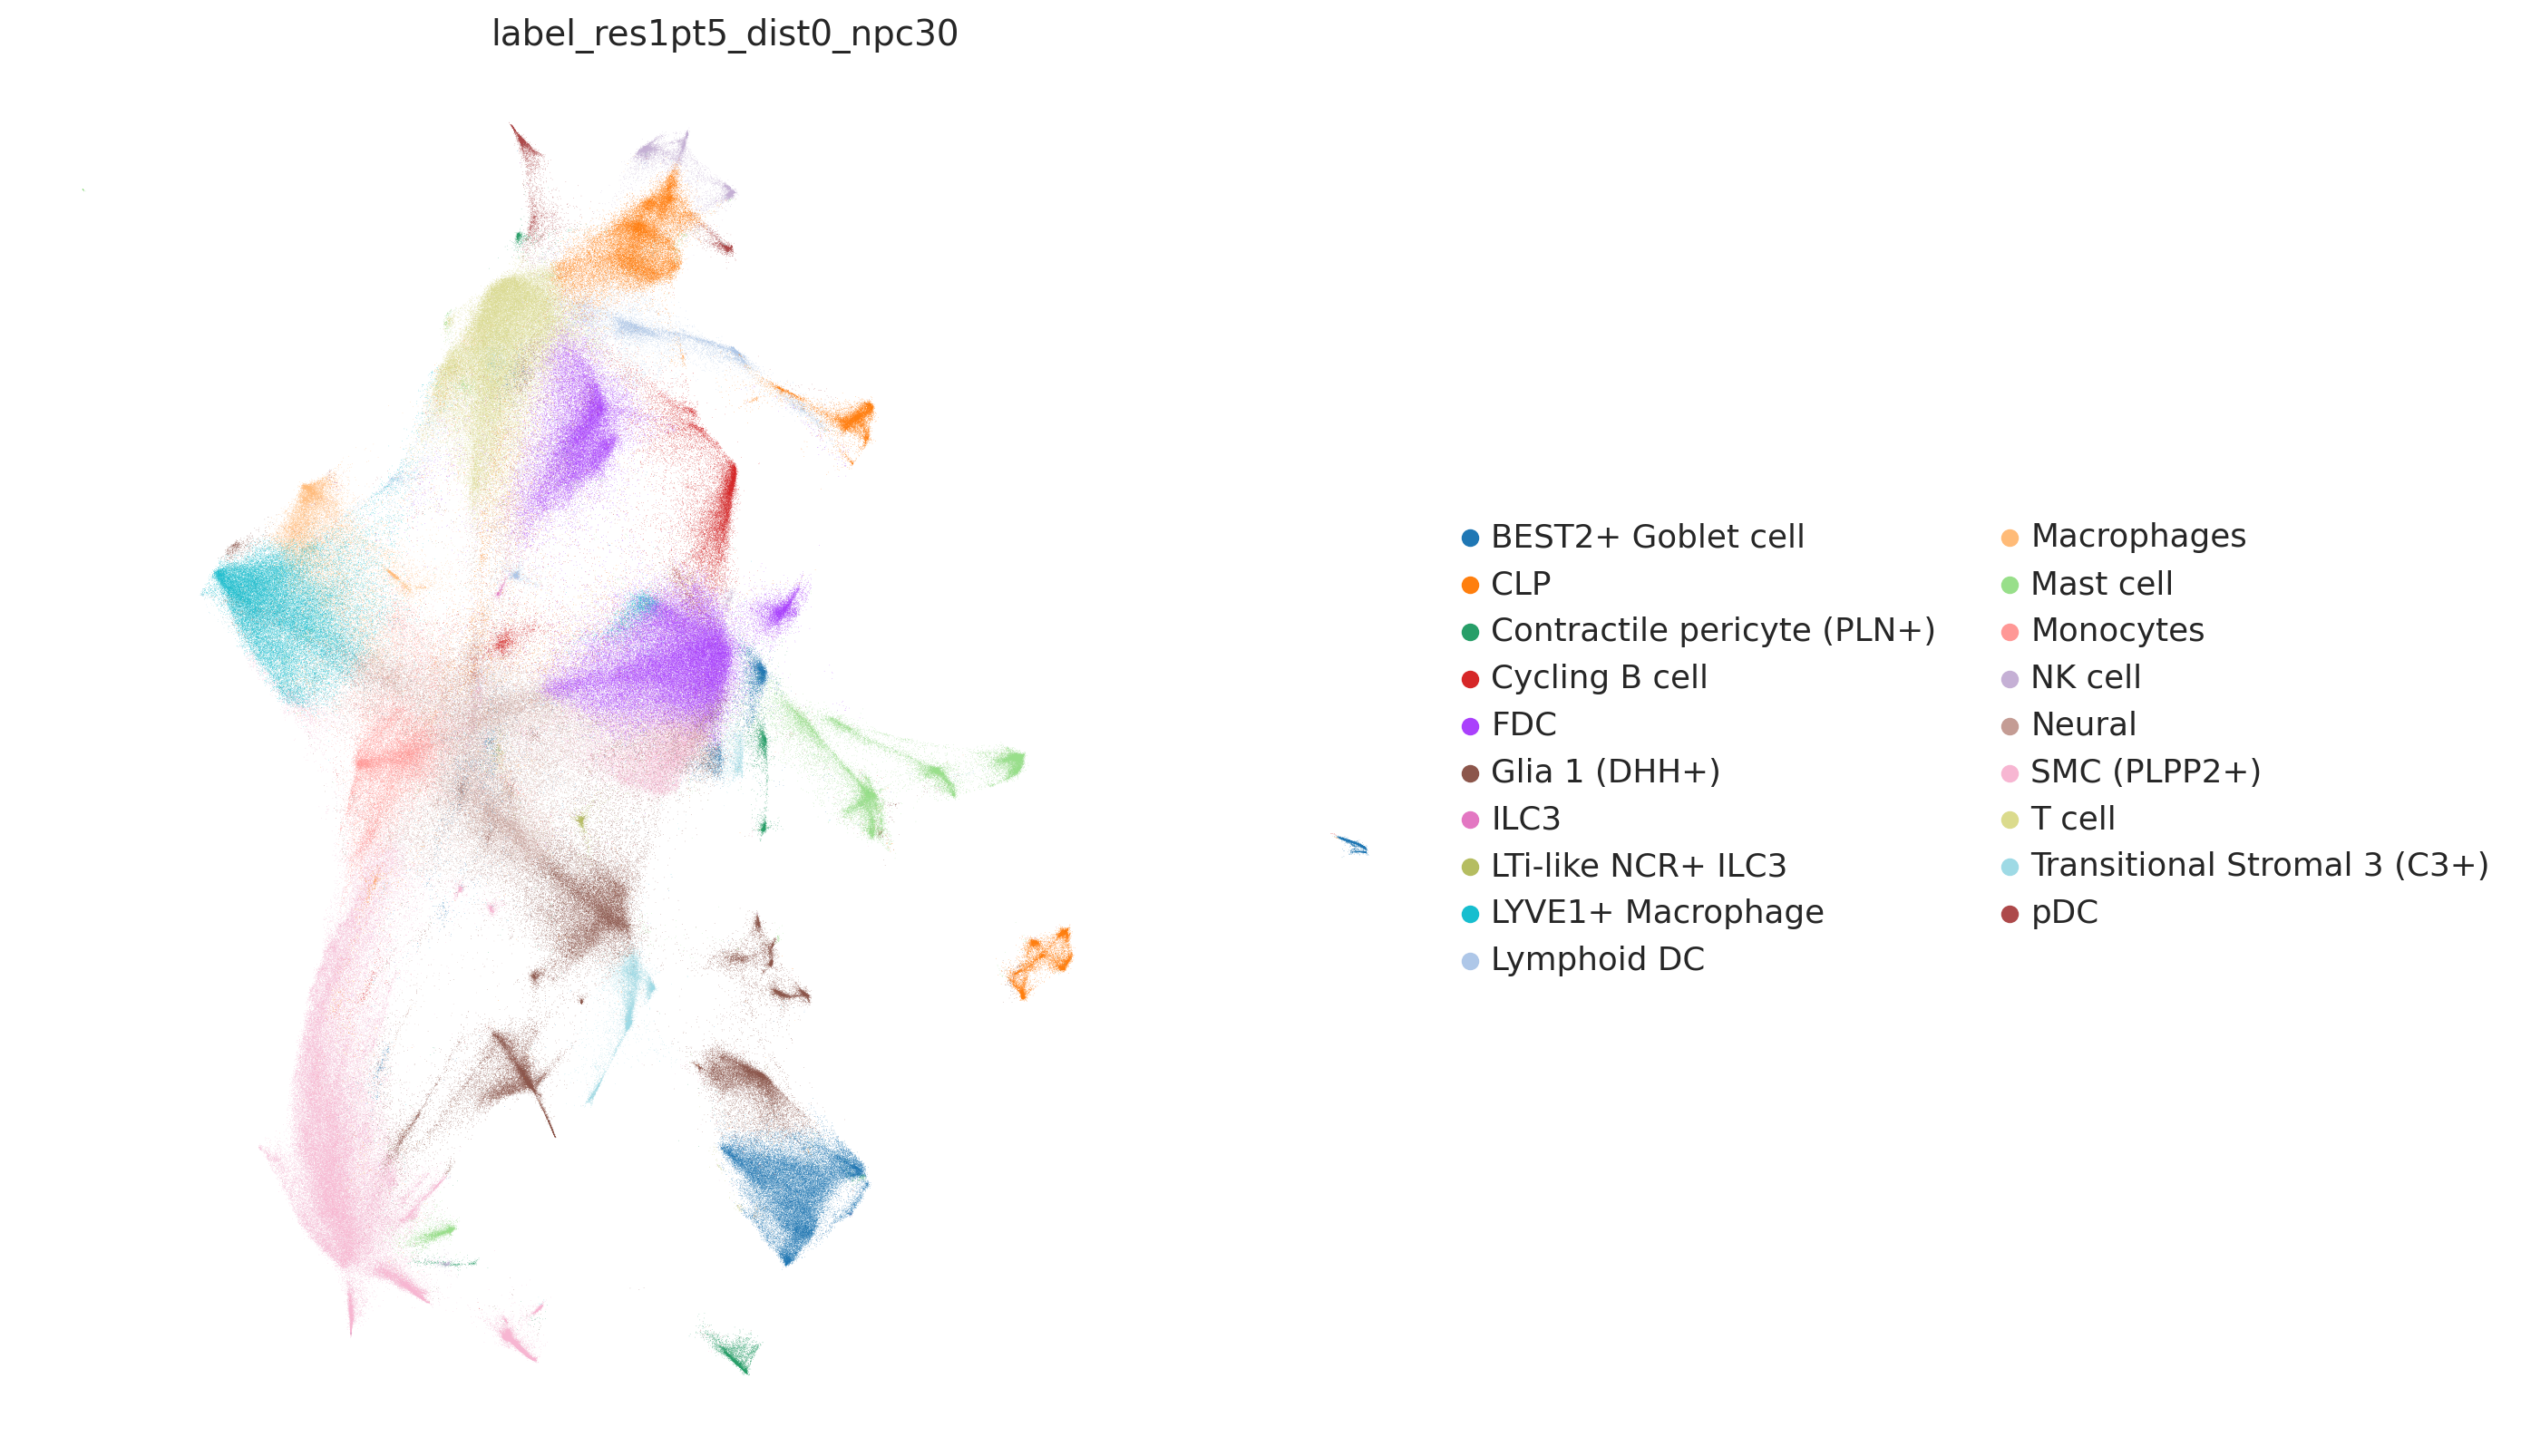

Markers File: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Stricture-50403C2___leiden_res1pt5_dist0_npc30_markers.csv
Clusters File: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Stricture-50403C2___leiden_res1pt5_dist0_npc30.csv


Markers File: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Stricture-50403C2___label_res1pt5_dist0_npc30_markers.csv
Clusters File: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Stricture-50403C2___label_res1pt5_dist0_npc30.csv




res0pt75_dist0pt3_npc30




Un-used Keyword Arguments: {'assay': None}


<<< PERFORMING PCA >>>
{'use_highly_variable': False, 'n_comps': 30, 'random_state': 0}



<<< COMPUTING NEIGHBORHOOD GRAPH >>>
{'random_state': 0, 'n_pcs': 30}



<<< EMBEDDING UMAP >>>
{'random_state': 0, 'method': 'umap', 'min_dist': 0.3}



<<< CLUSTERING WITH LEIDEN METHOD >>>
Resolution=0.75


In [3]:
%%time

for i, s in enumerate(selves):
    f_o = str(selves[i].rna.obs.out_file.iloc[0])

    # Preprocessing
    kpp = kws_pp_o if s.rna.obs[col_sample_id_o].isin(
        old_seg).iloc[0] is True else kws_pp  # old or new segment pp?
    print("\n\n", kpp, "\n\n")
    _ = s.preprocess(**kpp, figsize=(15, 15))  # preprocess

    # Clustering at Different Resolutions & Minimum Distances
    for j, x in enumerate(kws_clustering):

        # Variables & Output Files
        print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")
        cct, cca = f"leiden_{x}", f"label_{x}"  # Leiden & annotation columns
        annot = assign[[col_assignment[j]]]  # gene-annotation dictionary

        # Clustering, Markers, Annotation, & Writing Output
        if load is False or cct not in s.rna.obs:
            _ = s.cluster(**kws_clustering[x], key_added=cct, out_file=f_o)
        if load is False or f"rank_genes_groups_{cct}" not in s.rna.uns:
            _ = s.find_markers(col_cell_type=cct, kws_plot=False)  # DEGs
        if reannotate is True or load is False:  # annotate; Explorer files
            _ = s.annotate_clusters(annot, col_cell_type=cct,
                                    col_annotation=cca)  # annotate
            for c in [k for k in [cct, cca] if k in s.rna.obs]:  # Explorer
                s.write_clusters(out_dir, col_cell_type=c, overwrite=True,
                                 file_prefix=f"{s._library_id}__", n_top=True)

        # Write Final Object
        if load is False or reannotate is True and f_o is not None:
            s.write(f_o)

## Tangram Imputation

In [ ]:
%%time

if file_sc is not None:
    adata_sc = sc.read(file_sc)  # read whole tx'ome data for imputation
    if load is False:
        for i, s in enumerate(selves):
            out = s.impute(
                adata_sc.copy(), col_cell_type=col_cell_type_sc,
                mode="clusters", markers=None, plot=False, plot_density=False,
                plot_genes=None, col_annotation=col_tangram, out_file=None)
            out[0].write_h5ad(os.path.splitext(selves[
                0].rna.obs.out_file.iloc[0])[0] + "___tangram.h5ad")  # write
            s.write(s.rna.obs.out_file.iloc[0])
            s.write_clusters(out_dir, file_prefix=f"{s._library_id}___",
                             col_cell_type=col_tangram,
                             overwrite=True, n_top=True)
    s.plot_spatial(color=col_tangram)

## Plot Clusters

In [ ]:
for s in selves:
    s.plot_spatial(color=col_tangram)
    for j, x in enumerate(kws_clustering):
        _ = s.plot_spatial(color=[f"leiden_{x}",, f"label_{x}"])

## ToppGene & Marker Expression

In [ ]:
self = selves[0]
print(self._library_id)
self.get_layer("counts", inplace=True)

srcs = ["Cells of the human intestinal tract mapped across space and time",
        "Human Ileal Epithelial cells from Crohn’s Disease",
        "Human Ileal Immune cells from Crohn’s Disease"]
# c_t = "leiden_res0pt5_dist0pt5_npc30"
# c_t = "leiden_res0pt75_dist0pt3_npc30"
c_t = "leiden_res1pt5_dist0_npc30"
tgdf, mks = self.annotate_clusters(
        None, sources=srcs, col_cell_type=c_t, max_results=10000,
        name_pattern={srcs[0]: "SmallIntestine"}, p_threshold=1e-15,
        lfc_threshold=1.5, n_top_genes=20, n_top_annotations=40)
tgdf.loc[:, "Name"] = tgdf.Name.str.strip(
        " / Per Region, Age_group, Lineage, cell class, cell type   ").apply(
                lambda x: re.sub("SmallIntestine", "SmInt", " --- ".join(
                        x.split("|")[0].split("-"))))

### By Top Markers

In [ ]:
key_cluster = "14"
count_threshold = 1

print(tgdf.loc[key_cluster].iloc[:, :-3])
_, percs_exp, n_exp, genes, msg = self.print_markers(
    key_cluster, assign, col_cell_type=c_t, lfc_threshold=2,
    count_threshold=count_threshold, p_threshold=1e-15,
    print_threshold=15, n_top_genes=40)
print("\n\n", genes, "\n\n", n_exp.applymap(int), "\n\n\t", msg)
percs_exp.applymap(lambda x: x if x == "" else str(int(x)) + "%")

### By Genes

In [ ]:
key_cluster = "1"
_, percs_exp, n_exp, genes, msg = self.print_markers(
    key_cluster, assign, col_cell_type=c_t, lfc_threshold=None,
    count_threshold=1, p_threshold=1, n_top_genes=[
        "LGR5", "CCL25", "CDCA7", "TOP2A",
        "MUC2", "MUC5B", "MUC1", "MUC4", "KLK1", "ZG16", "BEST2",
        "BEST4", "CCL20"])
print("\n\n", genes, "\n\n", n_exp.applymap(int), "\n\n", msg)
percs_exp.applymap(lambda x: x if x == "" else str(int(x)) + "%")

In [ ]:
key_cluster = "10"
_, percs_exp, n_exp, genes, msg = self.print_markers(
    key_cluster, assign, col_cell_type=c_t, lfc_threshold=None,
    count_threshold=1, p_threshold=1, n_top_genes=[
        "LGR5", "CCL25", "CDCA7", "TOP2A",
        "MUC2", "MUC5B", "MUC1", "MUC4", "KLK1", "ZG16", "BEST2",
        "BEST4", "CCL20"])
print("\n\n", genes, "\n\n", n_exp.applymap(int), "\n\n", msg)
percs_exp.applymap(lambda x: x if x == "" else str(int(x)) + "%")

In [ ]:
key_cluster = "22"
_, percs_exp, n_exp, genes, msg = self.print_markers(
    key_cluster, assign, col_cell_type=c_t, lfc_threshold=None,
    count_threshold=1, p_threshold=1, n_top_genes=list(assign[
        assign.Bin == "SMC"].index.intersection(self.rna.var_names)))
print("\n\n", genes, "\n\n", n_exp.applymap(int), "\n\n")
print(msg)
percs_exp.applymap(lambda x: x if x == "" else str(int(x)) + "%")

In [ ]:
key_cluster = "24"
_, percs_exp, n_exp, genes, msg = self.print_markers(
    key_cluster, assign, col_cell_type=c_t, lfc_threshold=None,
    count_threshold=1, p_threshold=1, n_top_genes=list(assign[
        assign.Bucket == "T Cell"].index.intersection(
            self.rna.var_names)))
print("\n\n", genes, "\n\n", n_exp.applymap(int), "\n\n")
print(msg)
percs_exp.applymap(lambda x: x if x == "" else str(int(x)) + "%")

In [ ]:
key_cluster = "30"
_, percs_exp, n_exp, genes, msg = self.print_markers(
    key_cluster, assign, col_cell_type=c_t, lfc_threshold=None,
    count_threshold=1, p_threshold=1, n_top_genes=list(assign[
        assign.Bucket == "Neural-Glia"].index.intersection(self.rna.var_names)))
print("\n\n", genes, "\n\n", n_exp.applymap(int), "\n\n", msg)
percs_exp.applymap(lambda x: x if x == "" else str(int(x)) + "%")

### Sensitivity: % of Total Cells (Restricted to Comparison)

In [ ]:
# comp = ["0", "5", "8", "10", "18", "20", "34"]
comp = ["2", "7", "11", "21", "28"]
count_threshold = 1
key_cluster = "2"
_, percs_exp, n_exp, genes, msg = self.print_markers(
    key_cluster, assign, col_cell_type=c_t, lfc_threshold=None,
    key_compare=comp, count_threshold=count_threshold, p_threshold=1,
    n_top_genes=list(assign[assign.Lump == "Epithelial"].index.intersection(
        self.rna.var_names)) + ["TP53", "PLAUR"])
print("\n\n", genes, "\n\n", n_exp.applymap(int), "\n\n")
print(msg)
percs_exp.applymap(lambda x: x if x == "" else str(int(x)) + "%")

# Analyze

## Centrality Scores

In [ ]:
%%time

for s in selves:
    s.calculate_centrality(n_jobs=sc.settings.n_jobs)

## Neighborhood Enrichment Analysis

In [ ]:
%%time

for s in selves:
    _ = s.calculate_neighborhood(figsize=(60, 30))

## Cell Type Co-Occurrence

In [ ]:
%%time

for s in selves:
    _ = s.find_cooccurrence(figsize=(60, 20), kws_plot=dict(wspace=3))

## Spatial Clustering

In [ ]:
for s in selves:
    cct = f"leiden_spatial_{list(kws_clustering.keys())[-1]}"
    _ = s.cluster_spatial(key_added=cct,
                          **kws_clustering[list(kws_clustering.keys())[-1]])
    _ = s.find_markers(col_cell_type=cct, kws_plot=False)
    _ = s.annotate_clusters(assign[[col_assignment[-1]]], col_cell_type=cct,
                            col_annotation=f"annotation_{cct}")
    for c in [cct, f"annotation_{cct}"]:
        s.plot_spatial(c)
        if out_dir is not None:
            s.write_clusters(out_dir, col_cell_type=c,
                             n_top=True, overwrite=True,
                             file_prefix=f"{s._library_id}___")
    if out_dir is not None:
        s.write(str(s.rna.obs.out_file.iloc[0]))

## Spatially-Variable Genes

In [ ]:
%%time

kws = dict(kws_plot=dict(legend_fontsize="large"), figsize=(15, 15))
for s in selves:
    _ = s.find_svgs(genes=15, method="moran", n_perms=10, **kws)

## Receptor-Ligand Interactions

In [ ]:
%%time

for s in selves:
    kss, ktt = None, None
    _ = s.calculate_receptor_ligand(
        col_condition=False, p_threshold=0.01, remove_ns=True,
        figsize=(30, 20), top_n=25, key_sources=kss, key_targets=ktt)
    # s.calculate_receptor_ligand_spatial()

## Cell Type Composition 

In [ ]:
for s in selves:
    s.run_composition_analysis()

## GEX

In [ ]:
for s in selves:
    s.plot_spatial(color=["TNF", "IL23", col_cell_type])

In [ ]:
_ = self.calculate_spatial_distance("LTi-like NCR+ ILC3", genes="CSF2RB")

In [ ]:
adata = selves[0].rna.copy()
adata.X = adata.layers["counts"]
sq.tl.var_by_distance(
    adata, "LTi-like NCR+ ILC3", col_cell_type, library_key=col_sample_id,
    design_matrix_key="design_matrix", covariates=["Patient", "Inflamed"],
    metric="euclidean", spatial_key=self._spatial_key, copy=False)
sq.pl.var_by_distance(
    adata=adata, var=["CSF2RB", "CSF2RA", "IL7R"],
    anchor_key="LTi-like NCR+ ILC3",
    covariate="Inflamed")

# Workspace

## Cell Counts

## Counts (Re-Load)

In [ ]:
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

# ddd = "/home/asline01/projects/senescence/analysis"
ddd = os.path.join(ddu, "projects/senescence/analysis")
label = "snc"
c_l = "leiden_res1pt5_dist0_npc30"
c_m = "manual_" + "_".join(c_l.split("_")[1:])
# col_condition = "Condition"
# col_sample = "Sample"
# col_subject = "Patient"
# ddl = "/home/asline01/projects/data/shared-xenium-library"
# out_dir = os.path.join(ddl, "outputs", "TUQ97N", "nebraska")
g_c = ["CDKN1A", "TP53", "PLAUR"]

key_uninfl, key_infl, key_stric = "Uninflamed", "Inflamed", "Stricture"

snc = pd.read_csv(os.path.join(ddd, f"quantification_{label}.csv"))
fig = sb.catplot(snc, y="Ratio", x="Gene", hue=col_condition, col="Threshold",
                 hue_order=[key_uninfl, key_infl, key_stric],
                 palette=["blue", "red", "yellow"],
                 kind="box", sharey=False)
fig.fig.show()

tx_cts = pd.read_csv(os.path.join(
	ddd, f"quantification_{label}_tx_cts.csv"))
samp_map = tx_cts[[col_sample]]
for i, x in enumerate([col_condition, col_subject]):
	samp_map.loc[:, x] = tx_cts[col_sample].apply(
		lambda x: x.split("-")[i] if i == 0 else x.split("-")[i][:-1])
samp_map = samp_map.set_index(col_sample)
tx_cts = tx_cts.set_index(col_sample).join(samp_map)
tx_cts = tx_cts.set_index(col_condition, append=True).set_index(
    "Gene", append=True)["0"].to_frame(
        "Count").reorder_levels([1, 0, 2]).sort_index()

fig = sb.catplot(tx_cts, hue=col_condition, x=col_condition,
                 hue_order=[key_uninfl, key_infl, key_stric],
                 palette=["blue", "red", "yellow"],
				 y="Count", col="Gene", kind="box")
fig.fig.show()

keys = [g_c] + [list(p) for p in itertools.combinations(g_c, 2)]
vvs = pd.read_csv(os.path.join(ddd, f"quantification_ncells_{label}.csv"))
vvr = vvs.copy()  # to hold % instead of counts in Gene1/Gene2+ etc.
for x in ["/".join(k) + "+" for k in keys]:
    vvr.loc[:, x] = 100 * vvr[x] / vvr["n_cluster"]
vvr = vvr.set_index([col_subject, col_condition, c_l]).reorder_levels(
	[1, 0, 2]).sort_index()
vvr = vvr[["/".join(k) + "+" for k in keys]].rename_axis(
    "Label", axis=1).stack().to_frame("Percent")
vvr = vvr.reset_index().set_index([vvr.index.names[-1]] + list(
    vvr.index.names[:-1])).sort_index()

vvv = vvr.reset_index().astype({col_subject: str}).set_index(
    vvr.index.names).join(samp_map.reset_index().astype({
        col_subject: str}).set_index([col_condition, col_subject])[[
            col_sample]], on=[col_condition, col_subject]).reset_index(
                ).set_index(col_sample)
for libid in ["Uninflamed-50006B", "Inflamed-50006A", "Stricture-50006C"]:
    r = "res1pt5_dist0_npc30"
    fmr = os.path.join(out_dir, "annotation_dictionaries", str(
        f"{libid}___leiden_{r}_dictionary.xlsx"))  # mappings
    fmr = pd.read_excel(fmr).iloc[:, :2].astype(str)
    mans = dict(fmr.set_index(fmr.columns[0]).iloc[:, 0])
    vvv.loc[libid, f"manual_{r}"] = vvv.loc[libid, f"leiden_{r}"].astype(
        int).astype(str).replace(mans)  # Leiden -> manual annotation
vvv.loc[:, f"manual_{r}"] = vvv[f"manual_{r}"].astype("category")
vvv = vvv.reset_index().set_index(vvr.index.names)

In [ ]:
for x in vvv.reset_index()["Label"].unique():
    fig = sb.catplot(vvv.loc[x], x=c_m, y="Percent", sharex=False,
                     kind="bar", margin_titles=True,
                     hue_order=[key_uninfl, key_infl, key_stric],
                     palette=["blue", "red", "yellow"],
                     hue=col_condition, col=col_subject)
    fig.set_xticklabels(rotation=90)
    fig.set_yticklabels(rotation=30)
    fig.fig.tight_layout()
    fig.fig.suptitle(x)
    fig.fig.set_size_inches(30, 30)
    fig.fig.show()

## PA CD

In [ ]:
mks = pd.read_csv("/mnt/cho_lab/disk2/jiayuzh/projects/perianal-cd/analysis"
                  "/coreSC/output/output_2024-05-06_11.53.33/all_markers.csv",
                  index_col=0).rename_axis("gene_ix").reset_index(
                      ).set_index(["cluster", "gene"])
srcs = ["Cells of the human intestinal tract mapped across space and time",
        "Human Ileal Epithelial cells from Crohn’s Disease",
        "Human Ileal Immune cells from Crohn’s Disease"]
kwarg = dict(sources=srcs, max_results=10000,
              name_pattern={srcs[0]: "SmallIntestine"})
nta, ntg = 40, 20
mmm = mks[mks.p_val_adj <= 1e-15]
mmm = mmm[mmm.avg_log2FC >= 0.75]  # filter ~ LFC
mmm = mmm.groupby("cluster").apply(lambda x: x.iloc[:min(x.shape[
    0], ntg)]).reset_index(0, drop=True)  # only N top
types = mmm.reset_index().cluster.unique()
tgdf = pd.concat([cr.tl.get_topp_gene(
    list(mmm.loc[x].index.values), **kwargs, verbose=False).drop(
        "Source", axis=1).reset_index(0, drop=True).iloc[:nta]
    for x in types], keys=types)  # ToppGene results

In [ ]:
clus = 5
mcm = mmm[(mmm["pct.1"] >= 0.5) & (mmm["pct.2"] <= 0.33)].loc[clus]
ggg = list(mcm.iloc[:30].index)
print(", ".join(ggg), "\n")
mcm

In [ ]:
ggg = list(mmm.loc[clus].iloc[:30].index)
print(", ".join(ggg), "\n")
print(assign.loc[assign.index.intersection(ggg)].rename_axis(
    "gene").reset_index().groupby("group").apply(
        lambda x: ", ".join(x.gene.unique())))
tgdf.loc[clus]

## Manual Annotations

### Uninflamed-50452A

In [ ]:
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
s.get_layer("counts", inplace=True)
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "9"][:, "CD79A"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "9"][:, "CD79B"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "6"][:, "CD79A"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "6"][:, "CD79B"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "6"][
    :, "ADAMDEC1"].X > 0))

In [ ]:
for x in ["COL1A1", "PEG10", "RCN3"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "10"][:, x].X > 0))

In [ ]:
for x in ["BMP5", "F3", "MMP11", "CCL8", "NPY", "CH25H"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "15"][:, x].X > 0))

In [ ]:
for x in ["LGR5"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "16"][:, x].X > 0))

In [ ]:
for x in ["CRIP2", "KCNA5", "LBH", "NET1", "PLN", "RERGL"]:
    print(round(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "20"][:, x].X > 0) * 100, 0))

In [ ]:
for x in ["TPSAB1", "CMA1"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "21"][:, x].X > 0))

In [ ]:
for x in ["GNLY", "GZMB"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] != "23"][:, x].X > 0))

In [ ]:
for x in marker_genes_dict["Pericyte"]:
    print(int(100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "25"][
        :, x].X > 0)), " vs. ", int(100 * np.mean(s.rna[s.rna.obs[
            f"leiden_{r}"] != "25"][:, x].X > 0)))

In [ ]:
comp = "2"
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{r}"] == "11"][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == comp][
            :, x].X > 0))) + "%" for x in ["COL4A1", "COL4A2", "DLC1"]]))
print(f"\n...compared to {comp}")

In [ ]:
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{r}"] == "9"][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"] != "9"][
            :, x].X > 0))) + "%" for x in [
                "ZBTB38", "IFNAR2", "SELENOM", "XBP1"]]))

### Stricture-50452C

In [ ]:
# Memory B
# Stricture-50452C___leiden_res0.75_dist0.3_npc30
i = -1
s = selves[i]
r = "leiden_res0.75_dist0.3_npc30"
s.rna.obs.loc[:, f"leiden_{r}"] = s.rna.obs[
    f"leiden_{r}"].astype(float).astype(int).astype(str)
clid = "21"
comp = ["2", "16", "18"]
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{r}"] == clid][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"].isin(comp)][
            :, x].X > 0))) + "%" for x in [
                "GPR183", "HHEX", "INPP5D", "LRRK2"]]))
print(f"\n...compared to {comp}")

In [ ]:
# Naive B
# Stricture-50452C___leiden_res0.75_dist0.3_npc30
i = -1
s = selves[i]
r = "leiden_res0.75_dist0.3_npc30"
s.rna.obs.loc[:, f"leiden_{r}"] = s.rna.obs[
    f"leiden_{r}"].astype(float).astype(int).astype(str)
clid = "21"
comp = ["2", "16", "18"]
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{r}"] == clid][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"].isin(comp)][
            :, x].X > 0))) + "%" for x in [
                "IRF1", "LNPEP", "PLAC8", "IFITM1"]]))
print(f"\n...compared to {comp}")

### Uninflamed-50006B

In [ ]:
# Neural-Glia
# Uninflamed-50006B
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "24"
comp = ["19"]
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.Bin == "Neural"].index.intersection(
                s.rna.var_names).difference(assign[
                    assign.Bin == "Glia"].index)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Epithelial
# Uninflamed-50006B
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "26"
# comp = ["10", "28"]
# comp = ["1", "3", "4", "7", "8", "10", "20", "26"]
# comp = ["3", "4", "7", "8", "10", "26"]
comp = ["4", "7", "8", "9"]  # suspected goblets
# comp = ["8"]
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in [
            "MUC2", "MUC4", "MUC1", "KLK1", "ZG16",  # "FAM3D",
            "BEST2", "BEST4","LGR5", "CDCA7", "CCL20", "LYZ",
            "HCK", "MATK", "ZFHX3"]])  # Tuft markers
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Eptithelial
# Uninflamed-50006B
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "26"
comp = ["10", "28"]
# comp = ["1", "3", "4", "7", "8", "10", "20", "26"]
# comp = ["3", "4", "7", "8", "10", "26"]
# comp = ["4", "7", "8", "9"]  # suspected goblets
# comp = ["8"]
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in [
            "MUC5B", "KIT", "MARCKSL1", "NACA", "FAM3D", "LCN2", "IRF2BP2",
            "MUC4", "SATB2", "UQCRC1", "SLC39A8", "SERBP1", "TP53", "MYO10",
            "KLK1", "HMGB1", "HOXA3", "NR5A2", "CAT", "LIMA1", "COX8A",
            "LGALS9", "HMGB2", "CDCA7", "ZFP91", "MUC1", "ATF6B"]])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
ggc = ["HCK", "MATK", "ZFHX3"]
subs = s.rna[s.rna.obs[r] == clus].copy()
subs = sc.tl.score_genes(subs, ggc, score_name="|".join(ggc),
                         use_raw=False, copy=True)  # score co-GEX
np.mean(subs.obs["|".join(ggc)] > 0)

### Stricture-50006C

In [ ]:
# Stricture-50006C
# T Cell
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "22"
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.Bin == "T Cell"].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
# gDT
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "27"
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.group.apply(lambda x: "gdT" in x)
            ].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
# LEC
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "27"
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.group.apply(lambda x: "LEC" in x)
            ].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
# cDC
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "25"
# comp = list(s.rna.obs[r].unique())
comp = ["6"]
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.group == "cDC1"].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "21"
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.Bin == "Neural"].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "11"
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in ["LYVE1"]])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "27"
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.Bin == "Endothelial"].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "31"
comp = ["4"]
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.Bin == "Glia"].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

### Uninflamed-50336C


In [ ]:
# Stricture-50006C
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "9"
# comp = ["4"]
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.group == "LYVE1+ Macrophage"].index.intersection(
                s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "0"
# comp = ["4"]
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.Bucket == "B Cell"].index.intersection(
                s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
# Stem/TA
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
ggx = assign[assign["group"].isin(["Stem cells",
                                   "Proximal progenitor"])].index
# ggx = ["LGR5"]
clus = "13"
comp = ["2"]
# comp = list(s.rna.obs[r].unique())
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[r].isin(
        list(set(comp).difference(set([clus]))))][:, x].X > 0))) + "%"
    for x in set(ggx).intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
# Goblet
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
ggx = assign[assign["Bin"].isin(["Goblet"])].index
# ggx = ["LGR5"]
clus = "14"
comp = ["3"]
# comp = list(s.rna.obs[r].unique())
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[r].isin(
        list(set(comp).difference(set([clus]))))][:, x].X > 0))) + "%"
    for x in set(ggx).intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
# Stem/Paneth
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
ggx = ["LYZ", "LCN2", "RAMP1"]
clus = "19"
comp = ["3"]
# comp = list(s.rna.obs[r].unique())
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[r].isin(
        list(set(comp).difference(set([clus]))))][:, x].X > 0))) + "%"
    for x in set(ggx).intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
# Stem/Paneth
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
ggx = assign[assign["group"].isin(["Mast Cell"])].index
clus = "24"
comp = list(s.rna.obs[r].unique())
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[r].isin(
        list(set(comp).difference(set([clus]))))][:, x].X > 0))) + "%"
    for x in set(ggx).intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
# MF/DP
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
ggx = assign[assign["Bin"].isin(["Myofibroblast"])].index
clus = "31"
# comp = list(s.rna.obs[r].unique())
# comp = ["1", "6"]
comp = ["17", "22"]
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[r].isin(
        list(set(comp).difference(set([clus]))))][:, x].X > 0))) + "%"
    for x in set(ggx).intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
# SMC/MF/DP
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
ggx = assign[assign["Bin"].isin(["SMC"])].index
clus = "1"
comp = ["6"]
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[r].isin(
        list(set(comp).difference(set([clus]))))][:, x].X > 0))) + "%"
    for x in set(ggx).intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

## Senescence

In [ ]:
snc, thresh = [np.nan] * len(selves), [1, 2, 3, 4]
ggg = ["CDKN1A", "TP53", "PLAUR"]
for i, s in enumerate(selves):
    s.get_layer("counts", inplace=True)
    snc[i] = pd.DataFrame(dict(
        Gene=ggg * len(thresh), Threshold=[t for t in thresh for g in ggg],
        Count=np.nan, Total=[s.rna.n_obs] * len(ggg) * len(thresh))).assign(
            Sample=s._library_id, Condition=s._library_id.split(
                "-")[0]).set_index(["Threshold", "Gene"])
    for t in thresh:
        snc[i].loc[t, "Count"] = [np.sum(s.rna[:, g].X >= t)
                                  for g in snc[i].loc[t].index]
snc = pd.concat(snc).set_index("Sample", append=True).sort_index()
snc = snc.assign(Ratio=snc.Count / snc.Total)
fff = str("/home/elizabeth/elizabeth/projects/senescence/analysis"
          f"/quantification_snc{'_raw' if load is False else ''}.csv")
fff_raw = os.path.splitext(fff)[0] + "_raw.csv"
# # dff = pd.read_csv(fff).set_index(snc.index.names)
# # snc = pd.concat([dff, snc]).sort_index()
if load is True:
    snc_raw = pd.read_csv(fff_raw, index_col=np.arange(len(snc.index.names)))
    snc = pd.concat([snc_raw, snc], keys=["Raw", "Processed"], axis=1, names=[
        "Cell Counts"])
# snc.to_csv(fff)
snc

In [ ]:
sb.catplot(snc, x="Condition", y="Ratio", sharey=False, kind="box",
           col="Gene", row="Threshold", hue="Condition", margin_titles=True)

In [ ]:
tx_snc = {}
for s in selves:
    s.get_layer("counts", inplace=True)
    tx_snc[s._library_id] = pd.Series([s.rna[:, g].X.sum(
        ) for g in ggg], index=pd.Index(ggg, name="Gene"))
tx_snc = pd.concat(tx_snc, keys=tx_snc, names=["Sample", "Gene"])
fff = str("/home/elizabeth/elizabeth/projects/senescence/analysis/quantifica"
          f"tion_snc_tx_cts{'_raw' if load is False else ''}.csv")
fff_raw = os.path.splitext(fff)[0] + "_raw.csv"
if load is True:
    tx_os = pd.read_csv(fff_raw, index_col=np.arange(len(tx_snc.index.names)))
    tx_snc = pd.concat([tx_os.iloc[:, 0], tx_snc], keys=["Raw", "Processed"],
                       axis=1, names=["Transcript Counts"])
# tx_snc.to_csv(fff)
tx_snc

In [ ]:
vvs = vvs.join(pd.Series(dict(zip([s._library_id for s in selves], [s.rna.obs[
    col_condition].iloc[0] for s in selves]))).rename_axis(
        vvs.index.names[0]).to_frame(col_condition)).loc[vvs.index]

In [ ]:
c_t = "Senescence_Proxy"
ggg = ["CDKN1A", "TP53", "PLAUR"]
c_l = "leiden_res1pt5_dist0_npc30"
ct_thresh = 1

for s in selves:
    s.get_layer("counts", inplace=True)
    _ = s.score_coex(ggg, n_combos=[2, 3], inplace=True, threshold=ct_thresh)
keys = [ggg] + [list(p) for p in itertools.combinations(ggg, 2)]

vvs = {}
for k in keys:
    vcs = {}
    key = "/".join(k) + "+"
    for s in selves:
        if c_l in s.rna.obs:
            s.rna.obs.loc[:, c_t] = s.rna.obs["_".join(k)].replace(
                True, key).replace(False, "Other")
            vcs[s._library_id] = s.rna.obs[s.rna.obs[c_t] == key][
                c_l].value_counts().replace(0, np.nan).dropna()
    vvs[key] = pd.DataFrame(vcs).rename_axis("Sample", axis=1).stack(
        ).groupby("Sample").apply(lambda x: x.sort_values(
            ascending=False)).reset_index(0, drop=True)
vvs = pd.concat(vvs, axis=1).reorder_levels([1, 0])
for s in selves:
    if c_l not in s.rna.obs:
        continue
    clus_sizes = s.rna.obs[c_l].value_counts()
    vvs.loc[s._library_id, "n_cluster"] = list(vvs.loc[
        s._library_id].groupby(c_l).apply(lambda x: clus_sizes.loc[x.name]))
    if load is True:
        mks = cr.ax.make_marker_genes_df(
            s.rna, c_l, key_added=f"rank_genes_groups_{c_l}")
        vvs.loc[s._library_id, "top_markers"] = list(vvs.loc[
            s._library_id].groupby(c_l).apply(lambda x: ", ".join(
                mks.loc[x.name].head().index) if (
                    x.name in mks.index) else "").loc[
                        vvs.loc[s._library_id].index])
vvs = vvs.join(pd.Series(dict(zip([s._library_id for s in selves], [s.rna.obs[
    col_condition].iloc[0] for s in selves]))).rename_axis(
        vvs.index.names[0]).to_frame(col_condition)).loc[vvs.index]
vvs = vvs.join(pd.Series(dict(zip([s._library_id for s in selves], [s.rna.obs[
    col_subject].iloc[0] for s in selves]))).rename_axis(
        vvs.index.names[0]).to_frame(col_subject)).loc[vvs.index]
fff = str("/home/elizabeth/elizabeth/projects/senescence/analysis/"
          f"quantification_ncells_snc.csv")
# if os.path.exists(fff):
#     vcf = pd.read_csv(fff, index_col=vcs.index.names)  # previous file
#     vcf = vcf.loc[vcf.index.difference(vcs)]
#     vvs = pd.concat([vcf, vvs])
vvs.to_csv(fff)
vvs

In [ ]:
vvr = vvs.copy()  # to hold % instead of counts in Gene1/Gene2+ etc.
for x in ["/".join(k) + "+" for k in keys]:
    vvr.loc[:, x] = 100 * vvr[x] / vvr["n_cluster"]
vvr = vvr.set_index([col_subject, col_condition], append=True).reset_index(
    0, drop=True).reorder_levels([1, 2, 0]).sort_index()
vvr = vvr[["/".join(k) + "+" for k in keys]].rename_axis(
    "Label", axis=1).stack().to_frame("Percent")
vvr

In [ ]:
fig, axs = plt.subplots(figsize=(30, 50))
sb.catplot(vvr, x="Label", y="Percent", ax=axs,
           sharey=False, kind="box", margin_titles=True,
           row=c_l, col=col_subject, hue=col_condition)
fig.set_titles(col_template="{col_name}")
fig.set_xticklabels(rotation=30)

## CD34

In [ ]:
import matplotlib.pyplot as plt

gene = "CD34"
thr = np.arange(1, 15)  # thresholds
fig, axes = plt.subplots(1, len(selves))
for i, s in enumerate(selves):
    print(f"{s._library_id}: {np.sum(s.rna[:, gene].X > 0)} / {s.rna.n_obs}")
    a_x = axes[i].bar(thr, [np.sum(s.rna[:, gene].X >= i) for i in thr])
    axes[i].set_title(s._library_id)
    # for x in s.rna.obs[f"leiden_{r}"].unique():
    #     print(str(x) + ": " + np.mean(s.rna[s.rna.obs[
    #         f"leiden_{r}"] == x][:, "CD34"].X > 0))
fig.suptitle("Total Cells above Count Thresholds for CD34")

## CSF

### Cell Counts

In [ ]:
load = True
for s in selves:
    if os.path.exists(s.rna.obs.out_file.iloc[0] + ".h5ad"):
        pass
    else:
        print(s._library_id)

In [ ]:
csf, thresh, ggg = [np.nan] * len(selves), [1, 2, 3, 4], [
    "CSF1", "CSF2", "CSF3"]
for i, s in enumerate(selves):
    s.get_layer("counts", inplace=True)
    csf[i] = pd.DataFrame(dict(
        Gene=ggg * len(thresh), Threshold=[t for t in thresh for g in ggg],
        Count=np.nan, Total=[s.rna.n_obs] * len(ggg) * len(thresh))).assign(
            Sample=s._library_id, Condition=s._library_id.split(
                "-")[0]).set_index(["Threshold", "Gene"])
    for t in thresh:
        csf[i].loc[t, "Count"] = [np.sum(s.rna[:, g].X >= t)
                                  for g in csf[i].loc[t].index]
csf = pd.concat(csf).set_index("Sample", append=True).sort_index()
csf = csf.assign(Ratio=csf.Count / csf.Total)
fff = str("/home/elizabeth/elizabeth/projects/csf2rb/analysis"
          f"/quantification_csf{'_raw' if load is False else ''}.csv")
fff_raw = os.path.splitext(fff)[0] + "_raw.csv"
# # dff = pd.read_csv(fff).set_index(csf.index.names)
# # csf = pd.concat([dff, csf]).sort_index()
if load is True:
    csf_raw = pd.read_csv(fff_raw, index_col=np.arange(len(csf.index.names)))
    csf = pd.concat([csf_raw, csf], keys=["Raw", "Processed"], axis=1, names=[
        "Cell Counts"])
# csf.to_csv(fff)
csf

### Transcript Counts

In [ ]:
ggg = ["CSF1", "CSF2", "CSF3"]
tx_cts = {}
for s in selves:
    s.get_layer("counts", inplace=True)
    tx_cts[s._library_id] = pd.Series([s.rna[:, g].X.sum(
        ) for g in ggg], index=pd.Index(ggg, name="Gene"))
tx_cts = pd.concat(tx_cts, keys=tx_cts, names=["Sample", "Gene"])
fff = str("/home/elizabeth/elizabeth/projects/csf2rb/analysis/quantifica"
          f"tion_csf_tx_cts{'_raw' if load is False else ''}.csv")
fff_raw = os.path.splitext(fff)[0] + "_raw.csv"
if load is True:
    tx_o = pd.read_csv(fff_raw, index_col=np.arange(len(tx_cts.index.names)))
    tx_cts = pd.concat([tx_o.iloc[:, 0], tx_cts], keys=["Raw", "Processed"],
                       axis=1, names=["Transcript Counts"])
# tx_cts.to_csv(fff)
tx_cts

In [ ]:
sb.barplot(csf["Processed"], y="Ratio", hue="Gene", x="Threshold")

In [ ]:
print("Correlation: ", scipy.stats.pearsonr(csf.loc[1]["Processed"][
    "Count"], csf.loc[2]["Processed"]["Count"].loc[csf.loc[1][
        "Processed"]["Count"].index]))
csf.loc[1]["Processed"].assign(Difference=csf.loc[1]["Processed"][
    "Count"] - csf.loc[2]["Processed"]["Count"].loc[csf.loc[1][
        "Processed"]["Count"].index]).assign(Threshold_2=csf.loc[2][
            "Processed"]["Count"].loc[csf.loc[1]["Processed"]["Count"].index])

In [ ]:
scipy.stats.pearsonr(tx_cts["Raw"], tx_cts["Processed"])

### ILC Marker+ Cell Counts

In [ ]:
c_t = "ILC_Proxy"
ggg = ["IL7R", "KLRB1", "RORC"]
c_l = "leiden_res1pt5_dist0_npc30"

for s in selves:
    s.get_layer("counts", inplace=True)
    _ = s.score_coex(ggg, n_combos=[2, 3], inplace=True, threshold=1)
keys = [ggg] + [list(p) for p in itertools.combinations(ggg, 2)]

vvv = {}
for k in keys:
    vcs = {}
    key = "/".join(k) + "+"
    for s in selves:
        if c_l in s.rna.obs:
            s.rna.obs.loc[:, c_t] = s.rna.obs["_".join(k)].replace(
                True, key).replace(False, "Other")
            vcs[s._library_id] = s.rna.obs[s.rna.obs[c_t] == key][
                c_l].value_counts().replace(0, np.nan).dropna()
    vvv[key] = pd.DataFrame(vcs).rename_axis("Sample", axis=1).stack(
        ).groupby("Sample").apply(lambda x: x.sort_values(
            ascending=False)).reset_index(0, drop=True)
vvv = pd.concat(vvv, axis=1).reorder_levels([1, 0])
for s in selves:
    if c_l not in s.rna.obs:
        continue
    clus_sizes = s.rna.obs[c_l].value_counts()
    vvv.loc[s._library_id, "n_cluster"] = list(vvv.loc[
        s._library_id].groupby(c_l).apply(lambda x: clus_sizes.loc[x.name]))
    if load is True:
        mks = cr.ax.make_marker_genes_df(
            s.rna, c_l, key_added=f"rank_genes_groups_{c_l}")
        vvv.loc[s._library_id, "top_markers"] = list(vvv.loc[
            s._library_id].groupby(c_l).apply(lambda x: ", ".join(
                mks.loc[x.name].head().index) if (
                    x.name in mks.index) else "").loc[
                        vvv.loc[s._library_id].index])
fff = str("/home/elizabeth/elizabeth/projects/csf2rb/analysis/"
          f"quantification_ncells_ilc.csv")
# if os.path.exists(fff):
#     vcf = pd.read_csv(fff, index_col=vcs.index.names)  # previous file
#     vcf = vcf.loc[vcf.index.difference(vcs)]
#     vvv = pd.concat([vcf, vvv])
# vvv.to_csv(fff)
vvv

### Distance

In [ ]:
_ = s.calculate_spatial_distance(f"{'/'.join(ggg)}+", col_cell_type=c_t,
                                 genes="CSF2RB")

### Quantification Plots

In [ ]:
import seaborn as sb
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt

csfp = csf[csf.Condition.isin(["Inflamed", "Uninflamed"])].set_index(
    "Condition", append=True)[["Count", "Ratio"]].rename_axis(
        "Metric", axis=1).stack().to_frame("Score")
fig = sb.catplot(csfp.reset_index(), x="Gene", y="Score", col="Metric",
                 margin_titles=True,
                 row="Threshold", hue="Condition", kind="bar",
                 sharex=False, sharey=False)
for a in fig.axes[:, 1]:
    a.set_ylim([0, max(csfp.Ratio, 0.3)])
fig.fig.tight_layout()

In [ ]:
arg = dict(x="Gene", y="Ratio", hue="Condition", hue_order=[
    "Inflamed", "Uninflamed"], order=["CSF1", "CSF2"])
fig = sb.catplot(kind="bar", errorbar="se", row="Threshold", data=csfp, **arg)
pairs = [
    (("CSF1", "Inflamed"), ("CSF2", "Inflamed")),
    (("CSF1", "Uninflamed"), ("CSF2", "Uninflamed")),
    (("CSF1", "Uninflamed"), ("CSF1", "Inflamed")),
    (("CSF2", "Uninflamed"), ("CSF2", "Inflamed"))
]

ant = Annotator(None, pairs)
fig.map_dataframe(ant.plot_and_annotate_facets, plot_params=arg,
                  plot="boxplot", annotation_func="apply_test",
                  configuration={"test": "wilcox"})
plt.show()

In [ ]:
arg = dict(x="Gene", y="Ratio", hue="Condition", hue_order=[
    "Inflamed", "Uninflamed"], order=["CSF1", "CSF2"])
fig = sb.catplot(kind="bar", errorbar="se", row="Threshold", data=csfp, **arg)
pairs = [
    (("CSF1", "Inflamed"), ("CSF2", "Inflamed")),
    (("CSF1", "Uninflamed"), ("CSF2", "Uninflamed"))
]

ant = Annotator(None, pairs)
fig.map_dataframe(ant.plot_and_annotate_facets, plot_params=arg,
                  plot="boxplot", annotation_func="apply_test",
                  configuration={"test": "wilcox"})
plt.show()

In [ ]:
csfp = csf.reset_index()
arg = dict(x="Gene", y="Ratio", hue="Condition", hue_order=[
    "Inflamed", "Uninflamed"], order=["CSF1", "CSF2"])
fig = sb.catplot(kind="bar", errorbar="se", row="Threshold", data=csfp, **arg)
# fig.map(sb.stripplot, arg["x"], arg["y"], arg["hue"],
#         hue_order=arg["hue_order"], order=arg["order"], dodge=True,
#         palette=sb.color_palette(), alpha=0.6, linewidth=1)
pairs = [
    (("CSF1", "Inflamed"), ("CSF2", "Inflamed")),
    (("CSF1", "Uninflamed"), ("CSF2", "Uninflamed")),
    (("CSF1", "Uninflamed"), ("CSF1", "Inflamed")),
    (("CSF2", "Uninflamed"), ("CSF2", "Inflamed"))
]
for t, ax in fig.axes_dict.items():
        annot = Annotator(ax, pairs, **arg, data=csfp[csfp.Threshold == t])
        annot.configure(test="Mann-Whitney", text_format="simple",
                        loc="inside", verbose=2)
        annot.apply_test().annotate()

In [ ]:
csfp = csf[csf.Condition.isin(["Inflamed", "Uninflamed"])].set_index(
    "Condition", append=True)[["Count", "Ratio"]].rename_axis(
        "Metric", axis=1).stack().to_frame("Score")
fig = sb.catplot(csfp, x="Gene", y="Score", col="Metric", margin_titles=True,
                 row="Threshold", kind="bar", errorbar="se",
                 sharex=False, sharey=False)
for a in fig.axes[:, 1]:
    a.set_ylim([0, max([csf.Ratio.max(), 0.3])])
fig.fig.tight_layout()

## Aligned Images

In [ ]:
landmarks = ShapesModel.parse(
    np.array([[10556.699, 7829.764], [13959.155, 13522.025], [10621.200, 17392.116]]), geometry=0, radius=500
)
visium_sdata["visium_landmarks"] = visium_landmarks

xenium_landmarks = ShapesModel.parse(
    np.array([[9438.385, 13933.017], [24847.866, 5948.002], [34082.584, 15234.235]]), geometry=0, radius=500
)
xenium_sdata["xenium_landmarks"] = xenium_landmarks

In [ ]:
import spatialdata_io as sdio
from spatialdata.models import ShapesModel

fai = os.path.join(
    "~/corescpy/examples/data/spatial",
    "Stricture-50452C__P53Red_P16Green_DAPIBlue.ome.tif")
faa = os.path.join(
    "~/corescpy/examples/data/spatial",
    "Stricture-50452C__P53Red_P16Green_DAPIBlue_matrix.csv")

img = sdio.xenium_aligned_image(fai, faa)